In [4]:
import numerox as nx

nx.data.TRAIN_FILE = 'numerai_training_data.csv'
nx.data.TOURNAMENT_FILE = 'numerai_tournament_data.csv' 
 
data = nx.download('nr.zip')



nr.zip:   0%|                                                                                                             | 0.00/154M [00:00<?, ?B/s]

nr.zip:   0%|                                                                                                  | 1.02k/154M [00:00<5:57:26, 7.17kB/s]

nr.zip:   0%|                                                                                                  | 17.4k/154M [00:00<4:17:01, 9.97kB/s]

nr.zip:   0%|                                                                                                  | 34.8k/154M [00:00<3:06:17, 13.8kB/s]

nr.zip:   0%|                                                                                                  | 68.6k/154M [00:00<2:13:41, 19.2kB/s]

nr.zip:   0%|                                                                                                  | 87.0k/154M [00:00<1:39:38, 25.7kB/s]

nr.zip:   0%|                                                                               

nr.zip:  57%|████████████████████████████████████████████████████████▊                                           | 87.4M/154M [00:07<00:01, 37.4MB/s]

nr.zip:  60%|████████████████████████████████████████████████████████████                                        | 92.3M/154M [00:07<00:01, 40.1MB/s]

nr.zip:  63%|██████████████████████████████████████████████████████████████▋                                     | 96.5M/154M [00:07<00:01, 37.7MB/s]

nr.zip:  65%|█████████████████████████████████████████████████████████████████▉                                   | 100M/154M [00:08<00:01, 36.7MB/s]

nr.zip:  68%|████████████████████████████████████████████████████████████████████▋                                | 105M/154M [00:08<00:01, 36.5MB/s]

nr.zip:  72%|████████████████████████████████████████████████████████████████████████▋                            | 111M/154M [00:08<00:01, 41.2MB/s]

nr.zip:  75%|███████████████████████████████████████████████████████████████████████████▌     

In [6]:
data

region    train, validation, test, live
rows      836711
era       181, [era1, eraX]
x         50, min 0.0000, mean 0.5026, max 1.0000
y         mean 0.499616, fraction missing 0.3321

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
%%time

from pipe import *

eras_distinct = set(data.era) | as_list 

era_data = eras    \
        | select( lambda e: np.logical_and( data.region=='train', data.era==e ) ) \
        | select( lambda e: ( data.x[ e ], data.y[3][e] ) ) \
        | where( lambda e: e[0].shape[0] > 0 ) \
        | select( lambda e: train_test_split( e[0], e[1], test_size=0.33  ) ) \
        | as_list()

Wall time: 1min 19s


In [10]:
eras = list( data.era[data.region=='train'] ) | select( lambda e: int( e.replace('era','') ) ) | as_list

from keras.utils import to_categorical

eras_y = to_categorical(eras)

First build the era-predicting model

In [11]:
import matplotlib.pyplot as plt

def plot(history, val=True, train=True, title='Bernie', metric='loss'):
    if train:
        plt.plot(history.history[metric][2:])
    if val:
        plt.plot(history.history['val_%s' % (metric) ][2:])
        
    plt.title('model %s on %s!' %(metric, title))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    
    labels = []
    if train: 
        labels.append('train')
    if val: 
        labels.append('validation')
        
    plt.legend(labels, loc='upper left')
    plt.show()

In [12]:
%%time

Xtrain, Xtest, Ytrain, Ytest = train_test_split( data.x[ data.region=='train' ], eras_y, test_size=0.5 )

model_dense = Sequential([
    Dense(32, input_shape=(50,)),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(100),
    Dropout(0.3),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dense(100),
    Activation('relu'),
    Dropout(0.3),
    Dense(121),
    Activation('softmax'),
])

model_dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_crossentropy','acc'])

history = model_dense.fit(Xtrain, 
                    Ytrain, 
                    validation_data=(Xtest,Ytest), 
                    epochs=500, 
                    batch_size=10000, 
                    shuffle=True)



Train on 251366 samples, validate on 251366 samples
Epoch 1/500
251366/251366 [==============================] - ETA: 9:43 - loss: 4.7988 - categorical_crossentropy: 4.7988 - acc: 0.00 - ETA: 4:40 - loss: 4.7981 - categorical_crossentropy: 4.7981 - acc: 0.00 - ETA: 1:37 - loss: 4.7968 - categorical_crossentropy: 4.7968 - acc: 0.00 - ETA: 52s - loss: 4.7959 - categorical_crossentropy: 4.7959 - acc: 0.0090 - ETA: 31s - loss: 4.7952 - categorical_crossentropy: 4.7952 - acc: 0.009 - ETA: 19s - loss: 4.7947 - categorical_crossentropy: 4.7947 - acc: 0.009 - ETA: 11s - loss: 4.7941 - categorical_crossentropy: 4.7941 - acc: 0.009 - ETA: 6s - loss: 4.7937 - categorical_crossentropy: 4.7937 - acc: 0.009 - ETA: 2s - loss: 4.7929 - categorical_crossentropy: 4.7929 - acc: 0.00 - 25s 100us/step - loss: 4.7925 - categorical_crossentropy: 4.7925 - acc: 0.0093 - val_loss: 4.7871 - val_categorical_crossentropy: 4.7871 - val_acc: 0.0094
Epoch 2/500
251366/251366 [==============================] - ETA: 0s

251366/251366 [==============================] - ETA: 0s - loss: 4.7811 - categorical_crossentropy: 4.7811 - acc: 0.01 - ETA: 0s - loss: 4.7796 - categorical_crossentropy: 4.7796 - acc: 0.00 - ETA: 0s - loss: 4.7795 - categorical_crossentropy: 4.7795 - acc: 0.00 - ETA: 0s - loss: 4.7800 - categorical_crossentropy: 4.7800 - acc: 0.00 - ETA: 0s - loss: 4.7797 - categorical_crossentropy: 4.7797 - acc: 0.00 - ETA: 0s - loss: 4.7796 - categorical_crossentropy: 4.7796 - acc: 0.00 - ETA: 0s - loss: 4.7794 - categorical_crossentropy: 4.7794 - acc: 0.00 - ETA: 0s - loss: 4.7793 - categorical_crossentropy: 4.7793 - acc: 0.00 - ETA: 0s - loss: 4.7794 - categorical_crossentropy: 4.7794 - acc: 0.00 - 1s 3us/step - loss: 4.7794 - categorical_crossentropy: 4.7794 - acc: 0.0095 - val_loss: 4.7788 - val_categorical_crossentropy: 4.7788 - val_acc: 0.0099
Epoch 11/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7801 - categorical_crossentropy: 4.7801 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7741 - categorical_crossentropy: 4.7741 - acc: 0.00 - ETA: 0s - loss: 4.7746 - categorical_crossentropy: 4.7746 - acc: 0.01 - ETA: 0s - loss: 4.7741 - categorical_crossentropy: 4.7741 - acc: 0.01 - ETA: 0s - loss: 4.7740 - categorical_crossentropy: 4.7740 - acc: 0.01 - ETA: 0s - loss: 4.7736 - categorical_crossentropy: 4.7736 - acc: 0.01 - ETA: 0s - loss: 4.7737 - categorical_crossentropy: 4.7737 - acc: 0.01 - ETA: 0s - loss: 4.7734 - categorical_crossentropy: 4.7734 - acc: 0.01 - ETA: 0s - loss: 4.7735 - categorical_crossentropy: 4.7735 - acc: 0.01 - ETA: 0s - loss: 4.7736 - categorical_crossentropy: 4.7736 - acc: 0.01 - 1s 3us/step - loss: 4.7736 - categorical_crossentropy: 4.7736 - acc: 0.0103 - val_loss: 4.7719 - val_categorical_crossentropy: 4.7719 - val_acc: 0.0105
Epoch 20/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7739 - categorical_crossentropy: 4.7739 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7685 - categorical_crossentropy: 4.7685 - acc: 0.01 - ETA: 0s - loss: 4.7702 - categorical_crossentropy: 4.7702 - acc: 0.01 - ETA: 0s - loss: 4.7704 - categorical_crossentropy: 4.7704 - acc: 0.01 - ETA: 0s - loss: 4.7698 - categorical_crossentropy: 4.7698 - acc: 0.01 - ETA: 0s - loss: 4.7702 - categorical_crossentropy: 4.7702 - acc: 0.01 - ETA: 0s - loss: 4.7697 - categorical_crossentropy: 4.7697 - acc: 0.01 - ETA: 0s - loss: 4.7695 - categorical_crossentropy: 4.7695 - acc: 0.01 - ETA: 0s - loss: 4.7694 - categorical_crossentropy: 4.7694 - acc: 0.01 - ETA: 0s - loss: 4.7693 - categorical_crossentropy: 4.7693 - acc: 0.01 - 1s 3us/step - loss: 4.7693 - categorical_crossentropy: 4.7693 - acc: 0.0108 - val_loss: 4.7681 - val_categorical_crossentropy: 4.7681 - val_acc: 0.0108
Epoch 29/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7685 - categorical_crossentropy: 4.7685 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7652 - categorical_crossentropy: 4.7652 - acc: 0.01 - ETA: 0s - loss: 4.7660 - categorical_crossentropy: 4.7660 - acc: 0.01 - ETA: 0s - loss: 4.7657 - categorical_crossentropy: 4.7657 - acc: 0.01 - ETA: 0s - loss: 4.7656 - categorical_crossentropy: 4.7656 - acc: 0.01 - ETA: 0s - loss: 4.7661 - categorical_crossentropy: 4.7661 - acc: 0.01 - ETA: 0s - loss: 4.7661 - categorical_crossentropy: 4.7661 - acc: 0.01 - ETA: 0s - loss: 4.7663 - categorical_crossentropy: 4.7663 - acc: 0.01 - ETA: 0s - loss: 4.7663 - categorical_crossentropy: 4.7663 - acc: 0.01 - ETA: 0s - loss: 4.7661 - categorical_crossentropy: 4.7661 - acc: 0.01 - 1s 3us/step - loss: 4.7661 - categorical_crossentropy: 4.7661 - acc: 0.0117 - val_loss: 4.7650 - val_categorical_crossentropy: 4.7650 - val_acc: 0.0113
Epoch 38/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7639 - categorical_crossentropy: 4.7639 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7593 - categorical_crossentropy: 4.7593 - acc: 0.01 - ETA: 0s - loss: 4.7621 - categorical_crossentropy: 4.7621 - acc: 0.01 - ETA: 0s - loss: 4.7618 - categorical_crossentropy: 4.7618 - acc: 0.01 - ETA: 0s - loss: 4.7623 - categorical_crossentropy: 4.7623 - acc: 0.01 - ETA: 0s - loss: 4.7622 - categorical_crossentropy: 4.7622 - acc: 0.01 - ETA: 0s - loss: 4.7622 - categorical_crossentropy: 4.7622 - acc: 0.01 - ETA: 0s - loss: 4.7624 - categorical_crossentropy: 4.7624 - acc: 0.01 - ETA: 0s - loss: 4.7629 - categorical_crossentropy: 4.7629 - acc: 0.01 - ETA: 0s - loss: 4.7629 - categorical_crossentropy: 4.7629 - acc: 0.01 - 1s 3us/step - loss: 4.7629 - categorical_crossentropy: 4.7629 - acc: 0.0112 - val_loss: 4.7622 - val_categorical_crossentropy: 4.7622 - val_acc: 0.0118
Epoch 47/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7635 - categorical_crossentropy: 4.7635 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7582 - categorical_crossentropy: 4.7582 - acc: 0.01 - ETA: 0s - loss: 4.7606 - categorical_crossentropy: 4.7606 - acc: 0.01 - ETA: 0s - loss: 4.7603 - categorical_crossentropy: 4.7603 - acc: 0.01 - ETA: 0s - loss: 4.7603 - categorical_crossentropy: 4.7603 - acc: 0.01 - ETA: 0s - loss: 4.7598 - categorical_crossentropy: 4.7598 - acc: 0.01 - ETA: 0s - loss: 4.7601 - categorical_crossentropy: 4.7601 - acc: 0.01 - ETA: 0s - loss: 4.7600 - categorical_crossentropy: 4.7600 - acc: 0.01 - ETA: 0s - loss: 4.7599 - categorical_crossentropy: 4.7599 - acc: 0.01 - ETA: 0s - loss: 4.7599 - categorical_crossentropy: 4.7599 - acc: 0.01 - 1s 3us/step - loss: 4.7599 - categorical_crossentropy: 4.7599 - acc: 0.0119 - val_loss: 4.7584 - val_categorical_crossentropy: 4.7584 - val_acc: 0.0123
Epoch 56/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7590 - categorical_crossentropy: 4.7590 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7520 - categorical_crossentropy: 4.7520 - acc: 0.01 - ETA: 0s - loss: 4.7553 - categorical_crossentropy: 4.7553 - acc: 0.01 - ETA: 0s - loss: 4.7564 - categorical_crossentropy: 4.7564 - acc: 0.01 - ETA: 0s - loss: 4.7571 - categorical_crossentropy: 4.7571 - acc: 0.01 - ETA: 0s - loss: 4.7567 - categorical_crossentropy: 4.7567 - acc: 0.01 - ETA: 0s - loss: 4.7564 - categorical_crossentropy: 4.7564 - acc: 0.01 - ETA: 0s - loss: 4.7567 - categorical_crossentropy: 4.7567 - acc: 0.01 - ETA: 0s - loss: 4.7564 - categorical_crossentropy: 4.7564 - acc: 0.01 - ETA: 0s - loss: 4.7565 - categorical_crossentropy: 4.7565 - acc: 0.01 - 1s 3us/step - loss: 4.7565 - categorical_crossentropy: 4.7565 - acc: 0.0120 - val_loss: 4.7557 - val_categorical_crossentropy: 4.7557 - val_acc: 0.0125
Epoch 65/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7554 - categorical_crossentropy: 4.7554 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7543 - categorical_crossentropy: 4.7543 - acc: 0.01 - ETA: 0s - loss: 4.7545 - categorical_crossentropy: 4.7545 - acc: 0.01 - ETA: 0s - loss: 4.7545 - categorical_crossentropy: 4.7545 - acc: 0.01 - ETA: 0s - loss: 4.7550 - categorical_crossentropy: 4.7550 - acc: 0.01 - ETA: 0s - loss: 4.7546 - categorical_crossentropy: 4.7546 - acc: 0.01 - ETA: 0s - loss: 4.7544 - categorical_crossentropy: 4.7544 - acc: 0.01 - ETA: 0s - loss: 4.7541 - categorical_crossentropy: 4.7541 - acc: 0.01 - ETA: 0s - loss: 4.7541 - categorical_crossentropy: 4.7541 - acc: 0.01 - ETA: 0s - loss: 4.7542 - categorical_crossentropy: 4.7542 - acc: 0.01 - 1s 3us/step - loss: 4.7542 - categorical_crossentropy: 4.7542 - acc: 0.0124 - val_loss: 4.7536 - val_categorical_crossentropy: 4.7536 - val_acc: 0.0124
Epoch 74/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7562 - categorical_crossentropy: 4.7562 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7557 - categorical_crossentropy: 4.7557 - acc: 0.01 - ETA: 0s - loss: 4.7538 - categorical_crossentropy: 4.7538 - acc: 0.01 - ETA: 0s - loss: 4.7530 - categorical_crossentropy: 4.7530 - acc: 0.01 - ETA: 0s - loss: 4.7520 - categorical_crossentropy: 4.7520 - acc: 0.01 - ETA: 0s - loss: 4.7514 - categorical_crossentropy: 4.7514 - acc: 0.01 - ETA: 0s - loss: 4.7515 - categorical_crossentropy: 4.7515 - acc: 0.01 - ETA: 0s - loss: 4.7517 - categorical_crossentropy: 4.7517 - acc: 0.01 - ETA: 0s - loss: 4.7518 - categorical_crossentropy: 4.7518 - acc: 0.01 - ETA: 0s - loss: 4.7514 - categorical_crossentropy: 4.7514 - acc: 0.01 - 1s 3us/step - loss: 4.7515 - categorical_crossentropy: 4.7515 - acc: 0.0128 - val_loss: 4.7522 - val_categorical_crossentropy: 4.7522 - val_acc: 0.0126
Epoch 83/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7507 - categorical_crossentropy: 4.7507 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7481 - categorical_crossentropy: 4.7481 - acc: 0.01 - ETA: 0s - loss: 4.7493 - categorical_crossentropy: 4.7493 - acc: 0.01 - ETA: 0s - loss: 4.7496 - categorical_crossentropy: 4.7496 - acc: 0.01 - ETA: 0s - loss: 4.7490 - categorical_crossentropy: 4.7490 - acc: 0.01 - ETA: 0s - loss: 4.7486 - categorical_crossentropy: 4.7486 - acc: 0.01 - ETA: 0s - loss: 4.7488 - categorical_crossentropy: 4.7488 - acc: 0.01 - ETA: 0s - loss: 4.7494 - categorical_crossentropy: 4.7494 - acc: 0.01 - ETA: 0s - loss: 4.7498 - categorical_crossentropy: 4.7498 - acc: 0.01 - ETA: 0s - loss: 4.7500 - categorical_crossentropy: 4.7500 - acc: 0.01 - 1s 3us/step - loss: 4.7500 - categorical_crossentropy: 4.7500 - acc: 0.0129 - val_loss: 4.7501 - val_categorical_crossentropy: 4.7501 - val_acc: 0.0129
Epoch 92/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7481 - categorical_crossentropy: 4.7481 - acc: 0.01 - ETA: 0s - loss: 4

251366/251366 [==============================] - ETA: 0s - loss: 4.7469 - categorical_crossentropy: 4.7469 - acc: 0.01 - ETA: 0s - loss: 4.7464 - categorical_crossentropy: 4.7464 - acc: 0.01 - ETA: 0s - loss: 4.7474 - categorical_crossentropy: 4.7474 - acc: 0.01 - ETA: 0s - loss: 4.7482 - categorical_crossentropy: 4.7482 - acc: 0.01 - ETA: 0s - loss: 4.7488 - categorical_crossentropy: 4.7488 - acc: 0.01 - ETA: 0s - loss: 4.7484 - categorical_crossentropy: 4.7484 - acc: 0.01 - ETA: 0s - loss: 4.7481 - categorical_crossentropy: 4.7481 - acc: 0.01 - ETA: 0s - loss: 4.7482 - categorical_crossentropy: 4.7482 - acc: 0.01 - ETA: 0s - loss: 4.7483 - categorical_crossentropy: 4.7483 - acc: 0.01 - 1s 3us/step - loss: 4.7484 - categorical_crossentropy: 4.7484 - acc: 0.0129 - val_loss: 4.7502 - val_categorical_crossentropy: 4.7502 - val_acc: 0.0128
Epoch 101/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7490 - categorical_crossentropy: 4.7490 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7490 - categorical_crossentropy: 4.7490 - acc: 0.01 - ETA: 0s - loss: 4.7466 - categorical_crossentropy: 4.7466 - acc: 0.01 - ETA: 0s - loss: 4.7466 - categorical_crossentropy: 4.7466 - acc: 0.01 - ETA: 0s - loss: 4.7463 - categorical_crossentropy: 4.7463 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7465 - categorical_crossentropy: 4.7465 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - ETA: 0s - loss: 4.7470 - categorical_crossentropy: 4.7470 - acc: 0.01 - ETA: 0s - loss: 4.7470 - categorical_crossentropy: 4.7470 - acc: 0.01 - 1s 3us/step - loss: 4.7470 - categorical_crossentropy: 4.7470 - acc: 0.0131 - val_loss: 4.7491 - val_categorical_crossentropy: 4.7491 - val_acc: 0.0132
Epoch 110/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7431 - categorical_crossentropy: 4.7431 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7433 - categorical_crossentropy: 4.7433 - acc: 0.01 - ETA: 0s - loss: 4.7468 - categorical_crossentropy: 4.7468 - acc: 0.01 - ETA: 0s - loss: 4.7457 - categorical_crossentropy: 4.7457 - acc: 0.01 - ETA: 0s - loss: 4.7452 - categorical_crossentropy: 4.7452 - acc: 0.01 - ETA: 0s - loss: 4.7451 - categorical_crossentropy: 4.7451 - acc: 0.01 - ETA: 0s - loss: 4.7452 - categorical_crossentropy: 4.7452 - acc: 0.01 - ETA: 0s - loss: 4.7458 - categorical_crossentropy: 4.7458 - acc: 0.01 - ETA: 0s - loss: 4.7456 - categorical_crossentropy: 4.7456 - acc: 0.01 - ETA: 0s - loss: 4.7457 - categorical_crossentropy: 4.7457 - acc: 0.01 - 1s 3us/step - loss: 4.7457 - categorical_crossentropy: 4.7457 - acc: 0.0132 - val_loss: 4.7457 - val_categorical_crossentropy: 4.7457 - val_acc: 0.0132
Epoch 119/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7464 - categorical_crossentropy: 4.7464 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7424 - categorical_crossentropy: 4.7424 - acc: 0.01 - ETA: 0s - loss: 4.7433 - categorical_crossentropy: 4.7433 - acc: 0.01 - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.01 - ETA: 0s - loss: 4.7441 - categorical_crossentropy: 4.7441 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - ETA: 0s - loss: 4.7443 - categorical_crossentropy: 4.7443 - acc: 0.01 - 1s 3us/step - loss: 4.7444 - categorical_crossentropy: 4.7444 - acc: 0.0134 - val_loss: 4.7466 - val_categorical_crossentropy: 4.7466 - val_acc: 0.0134
Epoch 128/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7460 - categorical_crossentropy: 4.7460 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7453 - categorical_crossentropy: 4.7453 - acc: 0.01 - ETA: 0s - loss: 4.7429 - categorical_crossentropy: 4.7429 - acc: 0.01 - ETA: 0s - loss: 4.7426 - categorical_crossentropy: 4.7426 - acc: 0.01 - ETA: 0s - loss: 4.7436 - categorical_crossentropy: 4.7436 - acc: 0.01 - ETA: 0s - loss: 4.7437 - categorical_crossentropy: 4.7437 - acc: 0.01 - ETA: 0s - loss: 4.7435 - categorical_crossentropy: 4.7435 - acc: 0.01 - ETA: 0s - loss: 4.7430 - categorical_crossentropy: 4.7430 - acc: 0.01 - ETA: 0s - loss: 4.7429 - categorical_crossentropy: 4.7429 - acc: 0.01 - ETA: 0s - loss: 4.7427 - categorical_crossentropy: 4.7427 - acc: 0.01 - 1s 3us/step - loss: 4.7426 - categorical_crossentropy: 4.7426 - acc: 0.0134 - val_loss: 4.7457 - val_categorical_crossentropy: 4.7457 - val_acc: 0.0129
Epoch 137/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7511 - categorical_crossentropy: 4.7511 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7407 - categorical_crossentropy: 4.7407 - acc: 0.01 - ETA: 0s - loss: 4.7434 - categorical_crossentropy: 4.7434 - acc: 0.01 - ETA: 0s - loss: 4.7430 - categorical_crossentropy: 4.7430 - acc: 0.01 - ETA: 0s - loss: 4.7428 - categorical_crossentropy: 4.7428 - acc: 0.01 - ETA: 0s - loss: 4.7427 - categorical_crossentropy: 4.7427 - acc: 0.01 - ETA: 0s - loss: 4.7422 - categorical_crossentropy: 4.7422 - acc: 0.01 - ETA: 0s - loss: 4.7424 - categorical_crossentropy: 4.7424 - acc: 0.01 - ETA: 0s - loss: 4.7426 - categorical_crossentropy: 4.7426 - acc: 0.01 - ETA: 0s - loss: 4.7427 - categorical_crossentropy: 4.7427 - acc: 0.01 - 1s 3us/step - loss: 4.7426 - categorical_crossentropy: 4.7426 - acc: 0.0135 - val_loss: 4.7456 - val_categorical_crossentropy: 4.7456 - val_acc: 0.0134
Epoch 146/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7390 - categorical_crossentropy: 4.7390 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.01 - ETA: 0s - loss: 4.7404 - categorical_crossentropy: 4.7404 - acc: 0.01 - ETA: 0s - loss: 4.7405 - categorical_crossentropy: 4.7405 - acc: 0.01 - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7410 - categorical_crossentropy: 4.7410 - acc: 0.01 - ETA: 0s - loss: 4.7412 - categorical_crossentropy: 4.7412 - acc: 0.01 - ETA: 0s - loss: 4.7406 - categorical_crossentropy: 4.7406 - acc: 0.01 - ETA: 0s - loss: 4.7405 - categorical_crossentropy: 4.7405 - acc: 0.01 - ETA: 0s - loss: 4.7402 - categorical_crossentropy: 4.7402 - acc: 0.01 - 1s 3us/step - loss: 4.7402 - categorical_crossentropy: 4.7402 - acc: 0.0136 - val_loss: 4.7431 - val_categorical_crossentropy: 4.7431 - val_acc: 0.0134
Epoch 155/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7377 - categorical_crossentropy: 4.7377 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7373 - categorical_crossentropy: 4.7373 - acc: 0.01 - ETA: 0s - loss: 4.7401 - categorical_crossentropy: 4.7401 - acc: 0.01 - ETA: 0s - loss: 4.7396 - categorical_crossentropy: 4.7396 - acc: 0.01 - ETA: 0s - loss: 4.7400 - categorical_crossentropy: 4.7400 - acc: 0.01 - ETA: 0s - loss: 4.7396 - categorical_crossentropy: 4.7396 - acc: 0.01 - ETA: 0s - loss: 4.7403 - categorical_crossentropy: 4.7403 - acc: 0.01 - ETA: 0s - loss: 4.7402 - categorical_crossentropy: 4.7402 - acc: 0.01 - ETA: 0s - loss: 4.7400 - categorical_crossentropy: 4.7400 - acc: 0.01 - ETA: 0s - loss: 4.7400 - categorical_crossentropy: 4.7400 - acc: 0.01 - 1s 3us/step - loss: 4.7400 - categorical_crossentropy: 4.7400 - acc: 0.0139 - val_loss: 4.7397 - val_categorical_crossentropy: 4.7397 - val_acc: 0.0135
Epoch 164/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7394 - categorical_crossentropy: 4.7394 - acc: 0.01 - ETA: 0s - loss: 4.7396 - categorical_crossentropy: 4.7396 - acc: 0.01 - ETA: 0s - loss: 4.7391 - categorical_crossentropy: 4.7391 - acc: 0.01 - ETA: 0s - loss: 4.7389 - categorical_crossentropy: 4.7389 - acc: 0.01 - ETA: 0s - loss: 4.7389 - categorical_crossentropy: 4.7389 - acc: 0.01 - ETA: 0s - loss: 4.7384 - categorical_crossentropy: 4.7384 - acc: 0.01 - ETA: 0s - loss: 4.7381 - categorical_crossentropy: 4.7381 - acc: 0.01 - ETA: 0s - loss: 4.7383 - categorical_crossentropy: 4.7383 - acc: 0.01 - ETA: 0s - loss: 4.7379 - categorical_crossentropy: 4.7379 - acc: 0.01 - 1s 3us/step - loss: 4.7379 - categorical_crossentropy: 4.7379 - acc: 0.0139 - val_loss: 4.7424 - val_categorical_crossentropy: 4.7424 - val_acc: 0.0137
Epoch 173/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7390 - categorical_crossentropy: 4.7390 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7344 - categorical_crossentropy: 4.7344 - acc: 0.01 - ETA: 0s - loss: 4.7369 - categorical_crossentropy: 4.7369 - acc: 0.01 - ETA: 0s - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.01 - ETA: 0s - loss: 4.7361 - categorical_crossentropy: 4.7361 - acc: 0.01 - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 4.7368 - categorical_crossentropy: 4.7368 - acc: 0.01 - ETA: 0s - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.01 - ETA: 0s - loss: 4.7370 - categorical_crossentropy: 4.7370 - acc: 0.01 - ETA: 0s - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.01 - 1s 3us/step - loss: 4.7372 - categorical_crossentropy: 4.7372 - acc: 0.0139 - val_loss: 4.7410 - val_categorical_crossentropy: 4.7410 - val_acc: 0.0139
Epoch 182/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7373 - categorical_crossentropy: 4.7373 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7400 - categorical_crossentropy: 4.7400 - acc: 0.01 - ETA: 0s - loss: 4.7366 - categorical_crossentropy: 4.7366 - acc: 0.01 - ETA: 0s - loss: 4.7360 - categorical_crossentropy: 4.7360 - acc: 0.01 - ETA: 0s - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.01 - ETA: 0s - loss: 4.7363 - categorical_crossentropy: 4.7363 - acc: 0.01 - ETA: 0s - loss: 4.7356 - categorical_crossentropy: 4.7356 - acc: 0.01 - ETA: 0s - loss: 4.7351 - categorical_crossentropy: 4.7351 - acc: 0.01 - ETA: 0s - loss: 4.7356 - categorical_crossentropy: 4.7356 - acc: 0.01 - ETA: 0s - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.01 - 1s 3us/step - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.0142 - val_loss: 4.7388 - val_categorical_crossentropy: 4.7388 - val_acc: 0.0140
Epoch 191/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7361 - categorical_crossentropy: 4.7361 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7394 - categorical_crossentropy: 4.7394 - acc: 0.01 - ETA: 0s - loss: 4.7354 - categorical_crossentropy: 4.7354 - acc: 0.01 - ETA: 0s - loss: 4.7349 - categorical_crossentropy: 4.7349 - acc: 0.01 - ETA: 0s - loss: 4.7346 - categorical_crossentropy: 4.7346 - acc: 0.01 - ETA: 0s - loss: 4.7347 - categorical_crossentropy: 4.7347 - acc: 0.01 - ETA: 0s - loss: 4.7345 - categorical_crossentropy: 4.7345 - acc: 0.01 - ETA: 0s - loss: 4.7343 - categorical_crossentropy: 4.7343 - acc: 0.01 - ETA: 0s - loss: 4.7344 - categorical_crossentropy: 4.7344 - acc: 0.01 - ETA: 0s - loss: 4.7347 - categorical_crossentropy: 4.7347 - acc: 0.01 - 1s 3us/step - loss: 4.7348 - categorical_crossentropy: 4.7348 - acc: 0.0148 - val_loss: 4.7362 - val_categorical_crossentropy: 4.7362 - val_acc: 0.0142
Epoch 200/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7353 - categorical_crossentropy: 4.7353 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7365 - categorical_crossentropy: 4.7365 - acc: 0.01 - ETA: 0s - loss: 4.7313 - categorical_crossentropy: 4.7313 - acc: 0.01 - ETA: 0s - loss: 4.7320 - categorical_crossentropy: 4.7320 - acc: 0.01 - ETA: 0s - loss: 4.7327 - categorical_crossentropy: 4.7327 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - ETA: 0s - loss: 4.7333 - categorical_crossentropy: 4.7333 - acc: 0.01 - ETA: 0s - loss: 4.7329 - categorical_crossentropy: 4.7329 - acc: 0.01 - ETA: 0s - loss: 4.7327 - categorical_crossentropy: 4.7327 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - 1s 3us/step - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.0145 - val_loss: 4.7338 - val_categorical_crossentropy: 4.7338 - val_acc: 0.0144
Epoch 209/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7355 - categorical_crossentropy: 4.7355 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7298 - categorical_crossentropy: 4.7298 - acc: 0.01 - ETA: 0s - loss: 4.7317 - categorical_crossentropy: 4.7317 - acc: 0.01 - ETA: 0s - loss: 4.7324 - categorical_crossentropy: 4.7324 - acc: 0.01 - ETA: 0s - loss: 4.7328 - categorical_crossentropy: 4.7328 - acc: 0.01 - ETA: 0s - loss: 4.7323 - categorical_crossentropy: 4.7323 - acc: 0.01 - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 4.7320 - categorical_crossentropy: 4.7320 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - 1s 3us/step - loss: 4.7327 - categorical_crossentropy: 4.7327 - acc: 0.0146 - val_loss: 4.7352 - val_categorical_crossentropy: 4.7352 - val_acc: 0.0142
Epoch 218/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - ETA: 0s - loss: 4.7335 - categorical_crossentropy: 4.7335 - acc: 0.01 - ETA: 0s - loss: 4.7320 - categorical_crossentropy: 4.7320 - acc: 0.01 - ETA: 0s - loss: 4.7326 - categorical_crossentropy: 4.7326 - acc: 0.01 - ETA: 0s - loss: 4.7323 - categorical_crossentropy: 4.7323 - acc: 0.01 - ETA: 0s - loss: 4.7321 - categorical_crossentropy: 4.7321 - acc: 0.01 - ETA: 0s - loss: 4.7319 - categorical_crossentropy: 4.7319 - acc: 0.01 - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - ETA: 0s - loss: 4.7315 - categorical_crossentropy: 4.7315 - acc: 0.01 - 1s 3us/step - loss: 4.7314 - categorical_crossentropy: 4.7314 - acc: 0.0147 - val_loss: 4.7365 - val_categorical_crossentropy: 4.7365 - val_acc: 0.0139
Epoch 227/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7328 - categorical_crossentropy: 4.7328 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7280 - categorical_crossentropy: 4.7280 - acc: 0.01 - ETA: 0s - loss: 4.7299 - categorical_crossentropy: 4.7299 - acc: 0.01 - ETA: 0s - loss: 4.7306 - categorical_crossentropy: 4.7306 - acc: 0.01 - ETA: 0s - loss: 4.7309 - categorical_crossentropy: 4.7309 - acc: 0.01 - ETA: 0s - loss: 4.7302 - categorical_crossentropy: 4.7302 - acc: 0.01 - ETA: 0s - loss: 4.7307 - categorical_crossentropy: 4.7307 - acc: 0.01 - ETA: 0s - loss: 4.7308 - categorical_crossentropy: 4.7308 - acc: 0.01 - ETA: 0s - loss: 4.7313 - categorical_crossentropy: 4.7313 - acc: 0.01 - ETA: 0s - loss: 4.7312 - categorical_crossentropy: 4.7312 - acc: 0.01 - 1s 3us/step - loss: 4.7311 - categorical_crossentropy: 4.7311 - acc: 0.0149 - val_loss: 4.7335 - val_categorical_crossentropy: 4.7335 - val_acc: 0.0142
Epoch 236/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7325 - categorical_crossentropy: 4.7325 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7287 - categorical_crossentropy: 4.7287 - acc: 0.01 - ETA: 0s - loss: 4.7308 - categorical_crossentropy: 4.7308 - acc: 0.01 - ETA: 0s - loss: 4.7306 - categorical_crossentropy: 4.7306 - acc: 0.01 - ETA: 0s - loss: 4.7308 - categorical_crossentropy: 4.7308 - acc: 0.01 - ETA: 0s - loss: 4.7303 - categorical_crossentropy: 4.7303 - acc: 0.01 - ETA: 0s - loss: 4.7302 - categorical_crossentropy: 4.7302 - acc: 0.01 - ETA: 0s - loss: 4.7304 - categorical_crossentropy: 4.7304 - acc: 0.01 - ETA: 0s - loss: 4.7304 - categorical_crossentropy: 4.7304 - acc: 0.01 - 1s 3us/step - loss: 4.7304 - categorical_crossentropy: 4.7304 - acc: 0.0144 - val_loss: 4.7341 - val_categorical_crossentropy: 4.7341 - val_acc: 0.0146
Epoch 245/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7295 - categorical_crossentropy: 4.7295 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7307 - categorical_crossentropy: 4.7307 - acc: 0.01 - ETA: 0s - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.01 - ETA: 0s - loss: 4.7281 - categorical_crossentropy: 4.7281 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss: 4.7272 - categorical_crossentropy: 4.7272 - acc: 0.01 - ETA: 0s - loss: 4.7274 - categorical_crossentropy: 4.7274 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - 1s 3us/step - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.0149 - val_loss: 4.7343 - val_categorical_crossentropy: 4.7343 - val_acc: 0.0141
Epoch 254/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7300 - categorical_crossentropy: 4.7300 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7265 - categorical_crossentropy: 4.7265 - acc: 0.01 - ETA: 0s - loss: 4.7259 - categorical_crossentropy: 4.7259 - acc: 0.01 - ETA: 0s - loss: 4.7273 - categorical_crossentropy: 4.7273 - acc: 0.01 - ETA: 0s - loss: 4.7278 - categorical_crossentropy: 4.7278 - acc: 0.01 - ETA: 0s - loss: 4.7271 - categorical_crossentropy: 4.7271 - acc: 0.01 - ETA: 0s - loss: 4.7284 - categorical_crossentropy: 4.7284 - acc: 0.01 - ETA: 0s - loss: 4.7281 - categorical_crossentropy: 4.7281 - acc: 0.01 - ETA: 0s - loss: 4.7277 - categorical_crossentropy: 4.7277 - acc: 0.01 - ETA: 0s - loss: 4.7275 - categorical_crossentropy: 4.7275 - acc: 0.01 - 1s 3us/step - loss: 4.7276 - categorical_crossentropy: 4.7276 - acc: 0.0150 - val_loss: 4.7325 - val_categorical_crossentropy: 4.7325 - val_acc: 0.0147
Epoch 263/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7280 - categorical_crossentropy: 4.7280 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7256 - categorical_crossentropy: 4.7256 - acc: 0.01 - ETA: 0s - loss: 4.7242 - categorical_crossentropy: 4.7242 - acc: 0.01 - ETA: 0s - loss: 4.7264 - categorical_crossentropy: 4.7264 - acc: 0.01 - ETA: 0s - loss: 4.7262 - categorical_crossentropy: 4.7262 - acc: 0.01 - ETA: 0s - loss: 4.7259 - categorical_crossentropy: 4.7259 - acc: 0.01 - ETA: 0s - loss: 4.7257 - categorical_crossentropy: 4.7257 - acc: 0.01 - ETA: 0s - loss: 4.7261 - categorical_crossentropy: 4.7261 - acc: 0.01 - ETA: 0s - loss: 4.7260 - categorical_crossentropy: 4.7260 - acc: 0.01 - ETA: 0s - loss: 4.7260 - categorical_crossentropy: 4.7260 - acc: 0.01 - 1s 3us/step - loss: 4.7259 - categorical_crossentropy: 4.7259 - acc: 0.0146 - val_loss: 4.7295 - val_categorical_crossentropy: 4.7295 - val_acc: 0.0146
Epoch 272/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7229 - categorical_crossentropy: 4.7229 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7203 - categorical_crossentropy: 4.7203 - acc: 0.01 - ETA: 0s - loss: 4.7266 - categorical_crossentropy: 4.7266 - acc: 0.01 - ETA: 0s - loss: 4.7256 - categorical_crossentropy: 4.7256 - acc: 0.01 - ETA: 0s - loss: 4.7254 - categorical_crossentropy: 4.7254 - acc: 0.01 - ETA: 0s - loss: 4.7250 - categorical_crossentropy: 4.7250 - acc: 0.01 - ETA: 0s - loss: 4.7250 - categorical_crossentropy: 4.7250 - acc: 0.01 - ETA: 0s - loss: 4.7252 - categorical_crossentropy: 4.7252 - acc: 0.01 - ETA: 0s - loss: 4.7250 - categorical_crossentropy: 4.7250 - acc: 0.01 - ETA: 0s - loss: 4.7252 - categorical_crossentropy: 4.7252 - acc: 0.01 - 1s 3us/step - loss: 4.7252 - categorical_crossentropy: 4.7252 - acc: 0.0149 - val_loss: 4.7326 - val_categorical_crossentropy: 4.7326 - val_acc: 0.0145
Epoch 281/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7255 - categorical_crossentropy: 4.7255 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7238 - categorical_crossentropy: 4.7238 - acc: 0.01 - ETA: 0s - loss: 4.7261 - categorical_crossentropy: 4.7261 - acc: 0.01 - ETA: 0s - loss: 4.7248 - categorical_crossentropy: 4.7248 - acc: 0.01 - ETA: 0s - loss: 4.7237 - categorical_crossentropy: 4.7237 - acc: 0.01 - ETA: 0s - loss: 4.7234 - categorical_crossentropy: 4.7234 - acc: 0.01 - ETA: 0s - loss: 4.7239 - categorical_crossentropy: 4.7239 - acc: 0.01 - ETA: 0s - loss: 4.7236 - categorical_crossentropy: 4.7236 - acc: 0.01 - ETA: 0s - loss: 4.7238 - categorical_crossentropy: 4.7238 - acc: 0.01 - ETA: 0s - loss: 4.7241 - categorical_crossentropy: 4.7241 - acc: 0.01 - 1s 3us/step - loss: 4.7240 - categorical_crossentropy: 4.7240 - acc: 0.0150 - val_loss: 4.7277 - val_categorical_crossentropy: 4.7277 - val_acc: 0.0148
Epoch 290/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7182 - categorical_crossentropy: 4.7182 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7205 - categorical_crossentropy: 4.7205 - acc: 0.01 - ETA: 0s - loss: 4.7232 - categorical_crossentropy: 4.7232 - acc: 0.01 - ETA: 0s - loss: 4.7208 - categorical_crossentropy: 4.7208 - acc: 0.01 - ETA: 0s - loss: 4.7218 - categorical_crossentropy: 4.7218 - acc: 0.01 - ETA: 0s - loss: 4.7218 - categorical_crossentropy: 4.7218 - acc: 0.01 - ETA: 0s - loss: 4.7223 - categorical_crossentropy: 4.7223 - acc: 0.01 - ETA: 0s - loss: 4.7229 - categorical_crossentropy: 4.7229 - acc: 0.01 - ETA: 0s - loss: 4.7232 - categorical_crossentropy: 4.7232 - acc: 0.01 - ETA: 0s - loss: 4.7231 - categorical_crossentropy: 4.7231 - acc: 0.01 - 1s 3us/step - loss: 4.7231 - categorical_crossentropy: 4.7231 - acc: 0.0156 - val_loss: 4.7284 - val_categorical_crossentropy: 4.7284 - val_acc: 0.0149
Epoch 299/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7212 - categorical_crossentropy: 4.7212 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7181 - categorical_crossentropy: 4.7181 - acc: 0.01 - ETA: 0s - loss: 4.7225 - categorical_crossentropy: 4.7225 - acc: 0.01 - ETA: 0s - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.01 - ETA: 0s - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.01 - ETA: 0s - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.01 - ETA: 0s - loss: 4.7219 - categorical_crossentropy: 4.7219 - acc: 0.01 - ETA: 0s - loss: 4.7216 - categorical_crossentropy: 4.7216 - acc: 0.01 - ETA: 0s - loss: 4.7220 - categorical_crossentropy: 4.7220 - acc: 0.01 - ETA: 0s - loss: 4.7217 - categorical_crossentropy: 4.7217 - acc: 0.01 - 1s 3us/step - loss: 4.7217 - categorical_crossentropy: 4.7217 - acc: 0.0155 - val_loss: 4.7191 - val_categorical_crossentropy: 4.7191 - val_acc: 0.0155
Epoch 308/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7224 - categorical_crossentropy: 4.7224 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7238 - categorical_crossentropy: 4.7238 - acc: 0.01 - ETA: 0s - loss: 4.7200 - categorical_crossentropy: 4.7200 - acc: 0.01 - ETA: 0s - loss: 4.7221 - categorical_crossentropy: 4.7221 - acc: 0.01 - ETA: 0s - loss: 4.7217 - categorical_crossentropy: 4.7217 - acc: 0.01 - ETA: 0s - loss: 4.7212 - categorical_crossentropy: 4.7212 - acc: 0.01 - ETA: 0s - loss: 4.7216 - categorical_crossentropy: 4.7216 - acc: 0.01 - ETA: 0s - loss: 4.7217 - categorical_crossentropy: 4.7217 - acc: 0.01 - ETA: 0s - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.01 - ETA: 0s - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.01 - 1s 3us/step - loss: 4.7215 - categorical_crossentropy: 4.7215 - acc: 0.0152 - val_loss: 4.7274 - val_categorical_crossentropy: 4.7274 - val_acc: 0.0152
Epoch 317/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7180 - categorical_crossentropy: 4.7180 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7152 - categorical_crossentropy: 4.7152 - acc: 0.01 - ETA: 0s - loss: 4.7164 - categorical_crossentropy: 4.7164 - acc: 0.01 - ETA: 0s - loss: 4.7176 - categorical_crossentropy: 4.7176 - acc: 0.01 - ETA: 0s - loss: 4.7181 - categorical_crossentropy: 4.7181 - acc: 0.01 - ETA: 0s - loss: 4.7186 - categorical_crossentropy: 4.7186 - acc: 0.01 - ETA: 0s - loss: 4.7187 - categorical_crossentropy: 4.7187 - acc: 0.01 - ETA: 0s - loss: 4.7190 - categorical_crossentropy: 4.7190 - acc: 0.01 - ETA: 0s - loss: 4.7191 - categorical_crossentropy: 4.7191 - acc: 0.01 - ETA: 0s - loss: 4.7192 - categorical_crossentropy: 4.7192 - acc: 0.01 - 1s 3us/step - loss: 4.7191 - categorical_crossentropy: 4.7191 - acc: 0.0154 - val_loss: 4.7243 - val_categorical_crossentropy: 4.7243 - val_acc: 0.0151
Epoch 326/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7160 - categorical_crossentropy: 4.7160 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7161 - categorical_crossentropy: 4.7161 - acc: 0.01 - ETA: 0s - loss: 4.7176 - categorical_crossentropy: 4.7176 - acc: 0.01 - ETA: 0s - loss: 4.7189 - categorical_crossentropy: 4.7189 - acc: 0.01 - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss: 4.7180 - categorical_crossentropy: 4.7180 - acc: 0.01 - ETA: 0s - loss: 4.7187 - categorical_crossentropy: 4.7187 - acc: 0.01 - ETA: 0s - loss: 4.7185 - categorical_crossentropy: 4.7185 - acc: 0.01 - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.01 - 1s 3us/step - loss: 4.7188 - categorical_crossentropy: 4.7188 - acc: 0.0156 - val_loss: 4.7220 - val_categorical_crossentropy: 4.7220 - val_acc: 0.0150
Epoch 335/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7152 - categorical_crossentropy: 4.7152 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7166 - categorical_crossentropy: 4.7166 - acc: 0.01 - ETA: 0s - loss: 4.7187 - categorical_crossentropy: 4.7187 - acc: 0.01 - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss: 4.7184 - categorical_crossentropy: 4.7184 - acc: 0.01 - ETA: 0s - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.01 - ETA: 0s - loss: 4.7182 - categorical_crossentropy: 4.7182 - acc: 0.01 - ETA: 0s - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.01 - ETA: 0s - loss: 4.7186 - categorical_crossentropy: 4.7186 - acc: 0.01 - ETA: 0s - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.01 - 1s 3us/step - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.0151 - val_loss: 4.7297 - val_categorical_crossentropy: 4.7297 - val_acc: 0.0146
Epoch 344/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7158 - categorical_crossentropy: 4.7158 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7150 - categorical_crossentropy: 4.7150 - acc: 0.01 - ETA: 0s - loss: 4.7176 - categorical_crossentropy: 4.7176 - acc: 0.01 - ETA: 0s - loss: 4.7172 - categorical_crossentropy: 4.7172 - acc: 0.01 - ETA: 0s - loss: 4.7170 - categorical_crossentropy: 4.7170 - acc: 0.01 - ETA: 0s - loss: 4.7160 - categorical_crossentropy: 4.7160 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - ETA: 0s - loss: 4.7163 - categorical_crossentropy: 4.7163 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - ETA: 0s - loss: 4.7167 - categorical_crossentropy: 4.7167 - acc: 0.01 - 1s 3us/step - loss: 4.7167 - categorical_crossentropy: 4.7167 - acc: 0.0156 - val_loss: 4.7243 - val_categorical_crossentropy: 4.7243 - val_acc: 0.0146
Epoch 353/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7206 - categorical_crossentropy: 4.7206 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7133 - categorical_crossentropy: 4.7133 - acc: 0.01 - ETA: 0s - loss: 4.7169 - categorical_crossentropy: 4.7169 - acc: 0.01 - ETA: 0s - loss: 4.7168 - categorical_crossentropy: 4.7168 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - ETA: 0s - loss: 4.7163 - categorical_crossentropy: 4.7163 - acc: 0.01 - ETA: 0s - loss: 4.7163 - categorical_crossentropy: 4.7163 - acc: 0.01 - ETA: 0s - loss: 4.7169 - categorical_crossentropy: 4.7169 - acc: 0.01 - ETA: 0s - loss: 4.7169 - categorical_crossentropy: 4.7169 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - 1s 3us/step - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.0157 - val_loss: 4.7209 - val_categorical_crossentropy: 4.7209 - val_acc: 0.0155
Epoch 362/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7087 - categorical_crossentropy: 4.7087 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7238 - categorical_crossentropy: 4.7238 - acc: 0.01 - ETA: 0s - loss: 4.7189 - categorical_crossentropy: 4.7189 - acc: 0.01 - ETA: 0s - loss: 4.7159 - categorical_crossentropy: 4.7159 - acc: 0.01 - ETA: 0s - loss: 4.7163 - categorical_crossentropy: 4.7163 - acc: 0.01 - ETA: 0s - loss: 4.7162 - categorical_crossentropy: 4.7162 - acc: 0.01 - ETA: 0s - loss: 4.7156 - categorical_crossentropy: 4.7156 - acc: 0.01 - ETA: 0s - loss: 4.7152 - categorical_crossentropy: 4.7152 - acc: 0.01 - ETA: 0s - loss: 4.7148 - categorical_crossentropy: 4.7148 - acc: 0.01 - ETA: 0s - loss: 4.7145 - categorical_crossentropy: 4.7145 - acc: 0.01 - 1s 3us/step - loss: 4.7145 - categorical_crossentropy: 4.7145 - acc: 0.0159 - val_loss: 4.7246 - val_categorical_crossentropy: 4.7246 - val_acc: 0.0145
Epoch 371/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7156 - categorical_crossentropy: 4.7156 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7183 - categorical_crossentropy: 4.7183 - acc: 0.01 - ETA: 0s - loss: 4.7139 - categorical_crossentropy: 4.7139 - acc: 0.01 - ETA: 0s - loss: 4.7141 - categorical_crossentropy: 4.7141 - acc: 0.01 - ETA: 0s - loss: 4.7138 - categorical_crossentropy: 4.7138 - acc: 0.01 - ETA: 0s - loss: 4.7138 - categorical_crossentropy: 4.7138 - acc: 0.01 - ETA: 0s - loss: 4.7140 - categorical_crossentropy: 4.7140 - acc: 0.01 - ETA: 0s - loss: 4.7135 - categorical_crossentropy: 4.7135 - acc: 0.01 - ETA: 0s - loss: 4.7137 - categorical_crossentropy: 4.7137 - acc: 0.01 - ETA: 0s - loss: 4.7135 - categorical_crossentropy: 4.7135 - acc: 0.01 - 1s 4us/step - loss: 4.7134 - categorical_crossentropy: 4.7134 - acc: 0.0157 - val_loss: 4.7226 - val_categorical_crossentropy: 4.7226 - val_acc: 0.0149
Epoch 380/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7124 - categorical_crossentropy: 4.7124 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7119 - categorical_crossentropy: 4.7119 - acc: 0.01 - ETA: 0s - loss: 4.7117 - categorical_crossentropy: 4.7117 - acc: 0.01 - ETA: 0s - loss: 4.7106 - categorical_crossentropy: 4.7106 - acc: 0.01 - ETA: 0s - loss: 4.7116 - categorical_crossentropy: 4.7116 - acc: 0.01 - ETA: 0s - loss: 4.7113 - categorical_crossentropy: 4.7113 - acc: 0.01 - ETA: 0s - loss: 4.7118 - categorical_crossentropy: 4.7118 - acc: 0.01 - ETA: 0s - loss: 4.7121 - categorical_crossentropy: 4.7121 - acc: 0.01 - ETA: 0s - loss: 4.7119 - categorical_crossentropy: 4.7119 - acc: 0.01 - ETA: 0s - loss: 4.7121 - categorical_crossentropy: 4.7121 - acc: 0.01 - 1s 3us/step - loss: 4.7121 - categorical_crossentropy: 4.7121 - acc: 0.0156 - val_loss: 4.7164 - val_categorical_crossentropy: 4.7164 - val_acc: 0.0153
Epoch 389/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7063 - categorical_crossentropy: 4.7063 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7131 - categorical_crossentropy: 4.7131 - acc: 0.01 - ETA: 0s - loss: 4.7150 - categorical_crossentropy: 4.7150 - acc: 0.01 - ETA: 0s - loss: 4.7120 - categorical_crossentropy: 4.7120 - acc: 0.01 - ETA: 0s - loss: 4.7111 - categorical_crossentropy: 4.7111 - acc: 0.01 - ETA: 0s - loss: 4.7113 - categorical_crossentropy: 4.7113 - acc: 0.01 - ETA: 0s - loss: 4.7108 - categorical_crossentropy: 4.7108 - acc: 0.01 - ETA: 0s - loss: 4.7108 - categorical_crossentropy: 4.7108 - acc: 0.01 - ETA: 0s - loss: 4.7110 - categorical_crossentropy: 4.7110 - acc: 0.01 - ETA: 0s - loss: 4.7114 - categorical_crossentropy: 4.7114 - acc: 0.01 - 1s 3us/step - loss: 4.7114 - categorical_crossentropy: 4.7114 - acc: 0.0158 - val_loss: 4.7213 - val_categorical_crossentropy: 4.7213 - val_acc: 0.0149
Epoch 398/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7070 - categorical_crossentropy: 4.7070 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7083 - categorical_crossentropy: 4.7083 - acc: 0.01 - ETA: 0s - loss: 4.7132 - categorical_crossentropy: 4.7132 - acc: 0.01 - ETA: 0s - loss: 4.7118 - categorical_crossentropy: 4.7118 - acc: 0.01 - ETA: 0s - loss: 4.7110 - categorical_crossentropy: 4.7110 - acc: 0.01 - ETA: 0s - loss: 4.7109 - categorical_crossentropy: 4.7109 - acc: 0.01 - ETA: 0s - loss: 4.7111 - categorical_crossentropy: 4.7111 - acc: 0.01 - ETA: 0s - loss: 4.7113 - categorical_crossentropy: 4.7113 - acc: 0.01 - ETA: 0s - loss: 4.7109 - categorical_crossentropy: 4.7109 - acc: 0.01 - ETA: 0s - loss: 4.7106 - categorical_crossentropy: 4.7106 - acc: 0.01 - 1s 3us/step - loss: 4.7105 - categorical_crossentropy: 4.7105 - acc: 0.0159 - val_loss: 4.7161 - val_categorical_crossentropy: 4.7161 - val_acc: 0.0154
Epoch 407/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7072 - categorical_crossentropy: 4.7072 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7095 - categorical_crossentropy: 4.7095 - acc: 0.01 - ETA: 0s - loss: 4.7106 - categorical_crossentropy: 4.7106 - acc: 0.01 - ETA: 0s - loss: 4.7119 - categorical_crossentropy: 4.7119 - acc: 0.01 - ETA: 0s - loss: 4.7114 - categorical_crossentropy: 4.7114 - acc: 0.01 - ETA: 0s - loss: 4.7100 - categorical_crossentropy: 4.7100 - acc: 0.01 - ETA: 0s - loss: 4.7092 - categorical_crossentropy: 4.7092 - acc: 0.01 - ETA: 0s - loss: 4.7093 - categorical_crossentropy: 4.7093 - acc: 0.01 - ETA: 0s - loss: 4.7093 - categorical_crossentropy: 4.7093 - acc: 0.01 - ETA: 0s - loss: 4.7090 - categorical_crossentropy: 4.7090 - acc: 0.01 - 1s 3us/step - loss: 4.7091 - categorical_crossentropy: 4.7091 - acc: 0.0159 - val_loss: 4.7135 - val_categorical_crossentropy: 4.7135 - val_acc: 0.0157
Epoch 416/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7068 - categorical_crossentropy: 4.7068 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7091 - categorical_crossentropy: 4.7091 - acc: 0.01 - ETA: 0s - loss: 4.7066 - categorical_crossentropy: 4.7066 - acc: 0.01 - ETA: 0s - loss: 4.7083 - categorical_crossentropy: 4.7083 - acc: 0.01 - ETA: 0s - loss: 4.7075 - categorical_crossentropy: 4.7075 - acc: 0.01 - ETA: 0s - loss: 4.7075 - categorical_crossentropy: 4.7075 - acc: 0.01 - ETA: 0s - loss: 4.7079 - categorical_crossentropy: 4.7079 - acc: 0.01 - ETA: 0s - loss: 4.7082 - categorical_crossentropy: 4.7082 - acc: 0.01 - ETA: 0s - loss: 4.7077 - categorical_crossentropy: 4.7077 - acc: 0.01 - ETA: 0s - loss: 4.7074 - categorical_crossentropy: 4.7074 - acc: 0.01 - 1s 3us/step - loss: 4.7074 - categorical_crossentropy: 4.7074 - acc: 0.0162 - val_loss: 4.7159 - val_categorical_crossentropy: 4.7159 - val_acc: 0.0151
Epoch 425/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7057 - categorical_crossentropy: 4.7057 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7075 - categorical_crossentropy: 4.7075 - acc: 0.01 - ETA: 0s - loss: 4.7039 - categorical_crossentropy: 4.7039 - acc: 0.01 - ETA: 0s - loss: 4.7033 - categorical_crossentropy: 4.7033 - acc: 0.01 - ETA: 0s - loss: 4.7048 - categorical_crossentropy: 4.7048 - acc: 0.01 - ETA: 0s - loss: 4.7050 - categorical_crossentropy: 4.7050 - acc: 0.01 - ETA: 0s - loss: 4.7059 - categorical_crossentropy: 4.7059 - acc: 0.01 - ETA: 0s - loss: 4.7066 - categorical_crossentropy: 4.7066 - acc: 0.01 - ETA: 0s - loss: 4.7063 - categorical_crossentropy: 4.7063 - acc: 0.01 - ETA: 0s - loss: 4.7064 - categorical_crossentropy: 4.7064 - acc: 0.01 - 1s 3us/step - loss: 4.7063 - categorical_crossentropy: 4.7063 - acc: 0.0159 - val_loss: 4.7185 - val_categorical_crossentropy: 4.7185 - val_acc: 0.0155
Epoch 434/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6995 - categorical_crossentropy: 4.6995 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.6994 - categorical_crossentropy: 4.6994 - acc: 0.01 - ETA: 0s - loss: 4.7049 - categorical_crossentropy: 4.7049 - acc: 0.01 - ETA: 0s - loss: 4.7040 - categorical_crossentropy: 4.7040 - acc: 0.01 - ETA: 0s - loss: 4.7049 - categorical_crossentropy: 4.7049 - acc: 0.01 - ETA: 0s - loss: 4.7051 - categorical_crossentropy: 4.7051 - acc: 0.01 - ETA: 0s - loss: 4.7052 - categorical_crossentropy: 4.7052 - acc: 0.01 - ETA: 0s - loss: 4.7050 - categorical_crossentropy: 4.7050 - acc: 0.01 - ETA: 0s - loss: 4.7051 - categorical_crossentropy: 4.7051 - acc: 0.01 - ETA: 0s - loss: 4.7047 - categorical_crossentropy: 4.7047 - acc: 0.01 - 1s 3us/step - loss: 4.7047 - categorical_crossentropy: 4.7047 - acc: 0.0162 - val_loss: 4.7119 - val_categorical_crossentropy: 4.7119 - val_acc: 0.0157
Epoch 443/500
251366/251366 [==============================] - ETA: 0s - loss: 4.7025 - categorical_crossentropy: 4.7025 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7008 - categorical_crossentropy: 4.7008 - acc: 0.01 - ETA: 0s - loss: 4.7066 - categorical_crossentropy: 4.7066 - acc: 0.01 - ETA: 0s - loss: 4.7062 - categorical_crossentropy: 4.7062 - acc: 0.01 - ETA: 0s - loss: 4.7050 - categorical_crossentropy: 4.7050 - acc: 0.01 - ETA: 0s - loss: 4.7050 - categorical_crossentropy: 4.7050 - acc: 0.01 - ETA: 0s - loss: 4.7044 - categorical_crossentropy: 4.7044 - acc: 0.01 - ETA: 0s - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.01 - ETA: 0s - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.01 - ETA: 0s - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.01 - 1s 3us/step - loss: 4.7045 - categorical_crossentropy: 4.7045 - acc: 0.0163 - val_loss: 4.7070 - val_categorical_crossentropy: 4.7070 - val_acc: 0.0160
Epoch 452/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6981 - categorical_crossentropy: 4.6981 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7021 - categorical_crossentropy: 4.7021 - acc: 0.01 - ETA: 0s - loss: 4.7031 - categorical_crossentropy: 4.7031 - acc: 0.01 - ETA: 0s - loss: 4.7042 - categorical_crossentropy: 4.7042 - acc: 0.01 - ETA: 0s - loss: 4.7039 - categorical_crossentropy: 4.7039 - acc: 0.01 - ETA: 0s - loss: 4.7031 - categorical_crossentropy: 4.7031 - acc: 0.01 - ETA: 0s - loss: 4.7023 - categorical_crossentropy: 4.7023 - acc: 0.01 - ETA: 0s - loss: 4.7024 - categorical_crossentropy: 4.7024 - acc: 0.01 - ETA: 0s - loss: 4.7028 - categorical_crossentropy: 4.7028 - acc: 0.01 - ETA: 0s - loss: 4.7031 - categorical_crossentropy: 4.7031 - acc: 0.01 - 1s 3us/step - loss: 4.7030 - categorical_crossentropy: 4.7030 - acc: 0.0165 - val_loss: 4.7087 - val_categorical_crossentropy: 4.7087 - val_acc: 0.0157
Epoch 461/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6978 - categorical_crossentropy: 4.6978 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.6990 - categorical_crossentropy: 4.6990 - acc: 0.01 - ETA: 0s - loss: 4.7022 - categorical_crossentropy: 4.7022 - acc: 0.01 - ETA: 0s - loss: 4.7023 - categorical_crossentropy: 4.7023 - acc: 0.01 - ETA: 0s - loss: 4.7014 - categorical_crossentropy: 4.7014 - acc: 0.01 - ETA: 0s - loss: 4.7015 - categorical_crossentropy: 4.7015 - acc: 0.01 - ETA: 0s - loss: 4.7014 - categorical_crossentropy: 4.7014 - acc: 0.01 - ETA: 0s - loss: 4.7017 - categorical_crossentropy: 4.7017 - acc: 0.01 - ETA: 0s - loss: 4.7014 - categorical_crossentropy: 4.7014 - acc: 0.01 - ETA: 0s - loss: 4.7015 - categorical_crossentropy: 4.7015 - acc: 0.01 - 1s 3us/step - loss: 4.7015 - categorical_crossentropy: 4.7015 - acc: 0.0168 - val_loss: 4.7074 - val_categorical_crossentropy: 4.7074 - val_acc: 0.0156
Epoch 470/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6988 - categorical_crossentropy: 4.6988 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.6957 - categorical_crossentropy: 4.6957 - acc: 0.01 - ETA: 0s - loss: 4.7035 - categorical_crossentropy: 4.7035 - acc: 0.01 - ETA: 0s - loss: 4.7019 - categorical_crossentropy: 4.7019 - acc: 0.01 - ETA: 0s - loss: 4.7011 - categorical_crossentropy: 4.7011 - acc: 0.01 - ETA: 0s - loss: 4.7007 - categorical_crossentropy: 4.7007 - acc: 0.01 - ETA: 0s - loss: 4.7012 - categorical_crossentropy: 4.7012 - acc: 0.01 - ETA: 0s - loss: 4.7009 - categorical_crossentropy: 4.7009 - acc: 0.01 - ETA: 0s - loss: 4.7009 - categorical_crossentropy: 4.7009 - acc: 0.01 - ETA: 0s - loss: 4.7011 - categorical_crossentropy: 4.7011 - acc: 0.01 - 1s 3us/step - loss: 4.7010 - categorical_crossentropy: 4.7010 - acc: 0.0164 - val_loss: 4.7148 - val_categorical_crossentropy: 4.7148 - val_acc: 0.0154
Epoch 479/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6973 - categorical_crossentropy: 4.6973 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7083 - categorical_crossentropy: 4.7083 - acc: 0.01 - ETA: 0s - loss: 4.7013 - categorical_crossentropy: 4.7013 - acc: 0.01 - ETA: 0s - loss: 4.7001 - categorical_crossentropy: 4.7001 - acc: 0.01 - ETA: 0s - loss: 4.6998 - categorical_crossentropy: 4.6998 - acc: 0.01 - ETA: 0s - loss: 4.7000 - categorical_crossentropy: 4.7000 - acc: 0.01 - ETA: 0s - loss: 4.7002 - categorical_crossentropy: 4.7002 - acc: 0.01 - ETA: 0s - loss: 4.7006 - categorical_crossentropy: 4.7006 - acc: 0.01 - ETA: 0s - loss: 4.7006 - categorical_crossentropy: 4.7006 - acc: 0.01 - ETA: 0s - loss: 4.7007 - categorical_crossentropy: 4.7007 - acc: 0.01 - 1s 3us/step - loss: 4.7007 - categorical_crossentropy: 4.7007 - acc: 0.0161 - val_loss: 4.7081 - val_categorical_crossentropy: 4.7081 - val_acc: 0.0163
Epoch 488/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6951 - categorical_crossentropy: 4.6951 - acc: 0.01 - ETA: 0s - loss: 

251366/251366 [==============================] - ETA: 0s - loss: 4.7044 - categorical_crossentropy: 4.7044 - acc: 0.01 - ETA: 0s - loss: 4.7019 - categorical_crossentropy: 4.7019 - acc: 0.01 - ETA: 0s - loss: 4.7007 - categorical_crossentropy: 4.7007 - acc: 0.01 - ETA: 0s - loss: 4.7001 - categorical_crossentropy: 4.7001 - acc: 0.01 - ETA: 0s - loss: 4.7002 - categorical_crossentropy: 4.7002 - acc: 0.01 - ETA: 0s - loss: 4.6990 - categorical_crossentropy: 4.6990 - acc: 0.01 - ETA: 0s - loss: 4.6996 - categorical_crossentropy: 4.6996 - acc: 0.01 - ETA: 0s - loss: 4.6993 - categorical_crossentropy: 4.6993 - acc: 0.01 - ETA: 0s - loss: 4.6993 - categorical_crossentropy: 4.6993 - acc: 0.01 - 1s 3us/step - loss: 4.6992 - categorical_crossentropy: 4.6992 - acc: 0.0169 - val_loss: 4.6978 - val_categorical_crossentropy: 4.6978 - val_acc: 0.0167
Epoch 497/500
251366/251366 [==============================] - ETA: 0s - loss: 4.6984 - categorical_crossentropy: 4.6984 - acc: 0.01 - ETA: 0s - loss: 

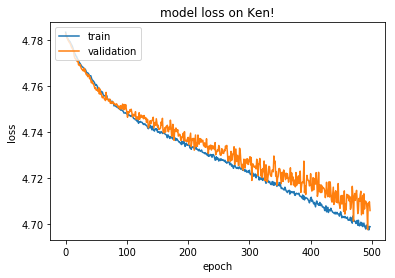

In [13]:
plot(history, title='Ken', metric='loss')

In [14]:
era_preds = np.argmax( model_dense.predict( data.x ), axis=1 )

In [15]:
from scipy import stats

stats.mode(era_preds)

ModeResult(mode=array([60], dtype=int64), count=array([172594]))

(array([1.25000e+02, 1.40000e+02, 7.48000e+02, 1.48100e+03, 2.24500e+03,
        2.04800e+03, 5.14000e+02, 3.10000e+01, 3.12900e+03, 1.24930e+04,
        3.30900e+03, 6.00000e+00, 2.90000e+01, 1.01690e+04, 6.91700e+03,
        4.01900e+03, 7.06000e+02, 1.70000e+01, 0.00000e+00, 2.76200e+04,
        1.04236e+05, 1.38040e+05, 8.75000e+02, 1.80296e+05, 1.19370e+04,
        3.12490e+04, 1.15270e+04, 1.57300e+03, 1.15800e+03, 8.03500e+03,
        1.53650e+04, 1.54660e+04, 4.09580e+04, 7.51680e+04, 1.03980e+04,
        1.52210e+04, 5.08900e+03, 2.27900e+03, 4.47000e+02, 1.72040e+04,
        1.82680e+04, 1.60750e+04, 9.44200e+03, 5.75200e+03, 2.13400e+03,
        9.17000e+02, 9.76500e+03, 7.33900e+03, 3.45500e+03, 1.29700e+03]),
 array([  5. ,   7.3,   9.6,  11.9,  14.2,  16.5,  18.8,  21.1,  23.4,
         25.7,  28. ,  30.3,  32.6,  34.9,  37.2,  39.5,  41.8,  44.1,
         46.4,  48.7,  51. ,  53.3,  55.6,  57.9,  60.2,  62.5,  64.8,
         67.1,  69.4,  71.7,  74. ,  76.3,  78.6,  80.9

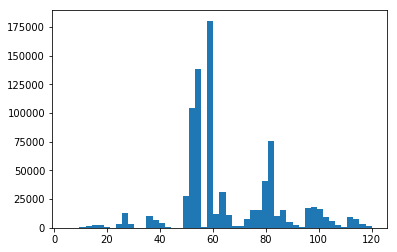

In [16]:
from matplotlib import pyplot

pyplot.hist(era_preds, bins=50)

In [17]:
len(era_data)

120

In [19]:
def GetEraModel(train_x, val_x, train_y, val_y ):

    model = Sequential([
        Dense(32, input_shape=(50,)),
        Activation('relu'),
        Dropout(0.3),
        Dense(100),
        Activation('relu'),
        Dense(100),
        Activation('relu'),
        Dropout(0.3),
        Dense(1),
        Activation('sigmoid'),
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_crossentropy'])

    history = model.fit(train_x, 
                        train_y, 
                        validation_data=(val_x,val_y), 
                        epochs=20, 
                        batch_size=1000, 
                        shuffle=True)
    
    return (model, history)



In [20]:
%%time
era_models = era_data | select( lambda era: GetEraModel( era[0], era[1], era[2], era[3] ) ) | as_list

Train on 2854 samples, validate on 1407 samples
Epoch 1/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6979 - binary_crossentropy: 0.697 - 1s 186us/step - loss: 0.6969 - binary_crossentropy: 0.6969 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 2/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 3/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 4/20
2854/2854 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2854/2854 [==============================] - ETA: 0s - loss

Epoch 18/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6845 - val_binary_crossentropy: 0.6845
Epoch 19/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6882 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6840 - val_binary_crossentropy: 0.6840
Epoch 20/20
2872/2872 [==============================] - ETA: 0s - loss: 0.6840 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6860 - binary_crossentropy: 0.6860 - val_loss: 0.6836 - val_binary_crossentropy: 0.6836
Train on 2937 samples, validate on 1447 samples
Epoch 1/20
2937/2937 [==============================] - ETA: 1s - loss: 0.7222 - binary_crossentropy: 0.722 - 1s 205us/step - loss: 0.7078 - binary_crossentropy: 0.7078 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2937/2937 [==============================] - ETA: 0s - l

Epoch 15/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6844 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6875 - binary_crossentropy: 0.6875 - val_loss: 0.6828 - val_binary_crossentropy: 0.6828
Epoch 16/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6868 - binary_crossentropy: 0.6868 - val_loss: 0.6823 - val_binary_crossentropy: 0.6823
Epoch 17/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6845 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6852 - binary_crossentropy: 0.6852 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 18/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 19/20
2702/2702 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 6u

Epoch 12/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6893 - binary_crossentropy: 0.6893 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 5us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 15/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 16/20
2731/2731 [==============================] - ETA: 0s - loss: 0.6837 - binary_crossentropy: 0.683 - 0s 5u

Epoch 9/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 10/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 5us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 12/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 13/20
2974/2974 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 6us

Epoch 6/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 7/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 8/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Epoch 9/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 5us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6882 - val_binary_crossentropy: 0.6882
Epoch 10/20
3276/3276 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 6us/st

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6973 - binary_crossentropy: 0.697 - 0s 5us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 5us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6887 - val_binary_crossentropy: 0.6887
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 5us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6886 - val_binary_crossentropy: 0.6886
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 6us/ste

Epoch 20/20
3005/3005 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6955 - val_binary_crossentropy: 0.6955
Train on 2600 samples, validate on 1282 samples
Epoch 1/20
2600/2600 [==============================] - ETA: 1s - loss: 0.6964 - binary_crossentropy: 0.696 - 1s 472us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 2/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6955 - binary_crossentropy: 0.695 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 3/20
2600/2600 [==============================] - ETA: 0s - loss: 0.6987 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 4/20
2600/2600 [==============================] - ETA: 0s - los

Epoch 17/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6836 - binary_crossentropy: 0.683 - 0s 6us/step - loss: 0.6850 - binary_crossentropy: 0.6850 - val_loss: 0.6765 - val_binary_crossentropy: 0.6765
Epoch 18/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 19/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6816 - binary_crossentropy: 0.681 - 0s 6us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6791 - val_binary_crossentropy: 0.6791
Epoch 20/20
3094/3094 [==============================] - ETA: 0s - loss: 0.6874 - binary_crossentropy: 0.687 - 0s 6us/step - loss: 0.6871 - binary_crossentropy: 0.6871 - val_loss: 0.6753 - val_binary_crossentropy: 0.6753
Train on 3135 samples, validate on 1545 samples
Epoch 1/20
3135/3135 [==============================] - ETA: 2s - lo

Epoch 14/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0s 6us/step - loss: 0.6744 - binary_crossentropy: 0.6744 - val_loss: 0.6710 - val_binary_crossentropy: 0.6710
Epoch 15/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 7us/step - loss: 0.6692 - binary_crossentropy: 0.6692 - val_loss: 0.6688 - val_binary_crossentropy: 0.6688
Epoch 16/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6794 - binary_crossentropy: 0.679 - 0s 7us/step - loss: 0.6741 - binary_crossentropy: 0.6741 - val_loss: 0.6672 - val_binary_crossentropy: 0.6672
Epoch 17/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 7us/step - loss: 0.6663 - binary_crossentropy: 0.6663 - val_loss: 0.6656 - val_binary_crossentropy: 0.6656
Epoch 18/20
2543/2543 [==============================] - ETA: 0s - loss: 0.6681 - binary_crossentropy: 0.668 - 0s 6u

Epoch 11/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6835 - binary_crossentropy: 0.683 - 0s 5us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6819 - val_binary_crossentropy: 0.6819
Epoch 12/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 5us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 13/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 5us/step - loss: 0.6849 - binary_crossentropy: 0.6849 - val_loss: 0.6802 - val_binary_crossentropy: 0.6802
Epoch 14/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6809 - binary_crossentropy: 0.680 - 0s 5us/step - loss: 0.6807 - binary_crossentropy: 0.6807 - val_loss: 0.6804 - val_binary_crossentropy: 0.6804
Epoch 15/20
2994/2994 [==============================] - ETA: 0s - loss: 0.6792 - binary_crossentropy: 0.679 - 0s 5u

Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 6us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6915 - val_binary_crossentropy: 0.6915
Epoch 9/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 5us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 11/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 5us/step - loss: 0.6904 - binary_crossentropy: 0.6904 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/

Epoch 5/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 6/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 7/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6886 - binary_crossentropy: 0.6886 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 8/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6887 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6883 - binary_crossentropy: 0.6883 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 9/20
2588/2588 [==============================] - ETA: 0s - loss: 0.6846 - binary_crossentropy: 0.684 - 0s 7us/ste

Epoch 2/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6981 - binary_crossentropy: 0.698 - 0s 6us/step - loss: 0.7009 - binary_crossentropy: 0.7009 - val_loss: 0.6957 - val_binary_crossentropy: 0.6957
Epoch 3/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6963 - binary_crossentropy: 0.696 - 0s 6us/step - loss: 0.6947 - binary_crossentropy: 0.6947 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 4/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6944 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 5/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6949 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 6/20
2954/2954 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 6us/ste

Epoch 19/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 20/20
3236/3236 [==============================] - ETA: 0s - loss: 0.6907 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Train on 3134 samples, validate on 1545 samples
Epoch 1/20
3134/3134 [==============================] - ETA: 3s - loss: 0.6986 - binary_crossentropy: 0.698 - 2s 627us/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6928 - val_binary_crossentropy: 0.6928
Epoch 2/20
3134/3134 [==============================] - ETA: 0s - loss: 0.6976 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6943 - val_binary_crossentropy: 0.6943
Epoch 3/20
3134/3134 [==============================] - ETA: 0s - lo

Epoch 16/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 17/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 18/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6893 - val_binary_crossentropy: 0.6893
Epoch 19/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6905 - binary_crossentropy: 0.6905 - val_loss: 0.6894 - val_binary_crossentropy: 0.6894
Epoch 20/20
3030/3030 [==============================] - ETA: 0s - loss: 0.6892 - binary_crossentropy: 0.689 - 0s 7u

Epoch 13/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 7us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6863 - val_binary_crossentropy: 0.6863
Epoch 14/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6889 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6901 - binary_crossentropy: 0.6901 - val_loss: 0.6859 - val_binary_crossentropy: 0.6859
Epoch 15/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 6us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6861 - val_binary_crossentropy: 0.6861
Epoch 16/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6853 - binary_crossentropy: 0.685 - 0s 6us/step - loss: 0.6864 - binary_crossentropy: 0.6864 - val_loss: 0.6853 - val_binary_crossentropy: 0.6853
Epoch 17/20
2866/2866 [==============================] - ETA: 0s - loss: 0.6849 - binary_crossentropy: 0.684 - 0s 6u

Epoch 10/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 7us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6897 - val_binary_crossentropy: 0.6897
Epoch 11/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6902 - binary_crossentropy: 0.6902 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 12/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6889 - val_binary_crossentropy: 0.6889
Epoch 13/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6885 - val_binary_crossentropy: 0.6885
Epoch 14/20
3286/3286 [==============================] - ETA: 0s - loss: 0.6894 - binary_crossentropy: 0.689 - 0s 6u

Epoch 7/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6970 - binary_crossentropy: 0.697 - 0s 7us/step - loss: 0.6943 - binary_crossentropy: 0.6943 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6910 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 9/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6949 - binary_crossentropy: 0.6949 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 11/20
3128/3128 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/s

Epoch 4/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6960 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 5/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 7us/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 6/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 8/20
2720/2720 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/ste

Train on 2283 samples, validate on 1125 samples
Epoch 1/20
2283/2283 [==============================] - ETA: 3s - loss: 0.6949 - binary_crossentropy: 0.694 - 3s 1ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6959 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6953 - binary_crossentropy: 0.6953 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 3/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6951 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 4/20
2283/2283 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 5/20
2283/2283 [==============================] - ETA: 0s - loss: 

Epoch 18/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6772 - val_binary_crossentropy: 0.6772
Epoch 19/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6855 - binary_crossentropy: 0.6855 - val_loss: 0.6771 - val_binary_crossentropy: 0.6771
Epoch 20/20
3042/3042 [==============================] - ETA: 0s - loss: 0.6789 - binary_crossentropy: 0.678 - 0s 7us/step - loss: 0.6833 - binary_crossentropy: 0.6833 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Train on 3209 samples, validate on 1582 samples
Epoch 1/20
3209/3209 [==============================] - ETA: 5s - loss: 0.6964 - binary_crossentropy: 0.696 - 3s 877us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 2/20
3209/3209 [==============================] - ETA: 0s - l

Epoch 15/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6874 - val_binary_crossentropy: 0.6874
Epoch 16/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 17/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6864 - val_binary_crossentropy: 0.6864
Epoch 18/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6856 - val_binary_crossentropy: 0.6856
Epoch 19/20
2132/2132 [==============================] - ETA: 0s - loss: 0.6858 - binary_crossentropy: 0.685 - 0s 8u

Epoch 12/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6900 - binary_crossentropy: 0.690 - 0s 6us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 13/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 6us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 14/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 15/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 16/20
2979/2979 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 7u

Epoch 9/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 10/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6926 - binary_crossentropy: 0.692 - 0s 6us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6918 - val_binary_crossentropy: 0.6918
Epoch 11/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6942 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6916 - val_binary_crossentropy: 0.6916
Epoch 12/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6914 - val_binary_crossentropy: 0.6914
Epoch 13/20
2968/2968 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 6us

Epoch 6/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6967 - binary_crossentropy: 0.6967 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 7/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6983 - binary_crossentropy: 0.698 - 0s 8us/step - loss: 0.6957 - binary_crossentropy: 0.6957 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 8/20
3287/3287 [==============================] - ETA: 0s - loss: 0.7013 - binary_crossentropy: 0.701 - 0s 7us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 9/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 10/20
3287/3287 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 7us/st

Epoch 3/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 7us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 4/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 5/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6946 - binary_crossentropy: 0.694 - 0s 7us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 6/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 7/20
2832/2832 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 6us/ste

Epoch 20/20
2830/2830 [==============================] - ETA: 0s - loss: 0.6884 - binary_crossentropy: 0.688 - 0s 7us/step - loss: 0.6887 - binary_crossentropy: 0.6887 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Train on 3148 samples, validate on 1551 samples
Epoch 1/20
3148/3148 [==============================] - ETA: 6s - loss: 0.6982 - binary_crossentropy: 0.698 - 4s 1ms/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 2/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6969 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
3148/3148 [==============================] - ETA: 0s - loss: 0.6948 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 4/20
3148/3148 [==============================] - ETA: 0s - loss:

Epoch 17/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 7us/step - loss: 0.6928 - binary_crossentropy: 0.6928 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 18/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 19/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 7us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 20/20
2651/2651 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 7us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Train on 2568 samples, validate on 1265 samples
Epoch 1/20
2568/2568 [==============================] - ETA: 5s - lo

Epoch 14/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6947 - binary_crossentropy: 0.694 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 15/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6940 - val_binary_crossentropy: 0.6940
Epoch 16/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 17/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6945 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 18/20
3177/3177 [==============================] - ETA: 0s - loss: 0.6927 - binary_crossentropy: 0.692 - 0s 8u

Epoch 11/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6915 - binary_crossentropy: 0.6915 - val_loss: 0.6908 - val_binary_crossentropy: 0.6908
Epoch 12/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6907 - val_binary_crossentropy: 0.6907
Epoch 13/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6936 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 14/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6906 - val_binary_crossentropy: 0.6906
Epoch 15/20
1601/1601 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 8

Epoch 8/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6866 - val_binary_crossentropy: 0.6866
Epoch 9/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6868 - binary_crossentropy: 0.686 - 0s 9us/step - loss: 0.6870 - binary_crossentropy: 0.6870 - val_loss: 0.6852 - val_binary_crossentropy: 0.6852
Epoch 10/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6842 - val_binary_crossentropy: 0.6842
Epoch 11/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6867 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 12/20
1717/1717 [==============================] - ETA: 0s - loss: 0.6842 - binary_crossentropy: 0.684 - 0s 8us

Epoch 5/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 6/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6890 - binary_crossentropy: 0.6890 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 7/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6891 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6888 - binary_crossentropy: 0.6888 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 8/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 9/20
2399/2399 [==============================] - ETA: 0s - loss: 0.6885 - binary_crossentropy: 0.688 - 0s 10us/

Epoch 2/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6978 - binary_crossentropy: 0.697 - 0s 10us/step - loss: 0.6959 - binary_crossentropy: 0.6959 - val_loss: 0.6941 - val_binary_crossentropy: 0.6941
Epoch 3/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6983 - binary_crossentropy: 0.6983 - val_loss: 0.6956 - val_binary_crossentropy: 0.6956
Epoch 4/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6978 - binary_crossentropy: 0.6978 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 5/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6942 - binary_crossentropy: 0.6942 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 6/20
1624/1624 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us/

Epoch 19/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6876 - binary_crossentropy: 0.687 - 0s 8us/step - loss: 0.6891 - binary_crossentropy: 0.6891 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 20/20
2646/2646 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 8us/step - loss: 0.6879 - binary_crossentropy: 0.6879 - val_loss: 0.6884 - val_binary_crossentropy: 0.6884
Train on 2828 samples, validate on 1394 samples
Epoch 1/20
2828/2828 [==============================] - ETA: 7s - loss: 0.7011 - binary_crossentropy: 0.701 - 4s 2ms/step - loss: 0.6995 - binary_crossentropy: 0.6995 - val_loss: 0.6949 - val_binary_crossentropy: 0.6949
Epoch 2/20
2828/2828 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6961 - binary_crossentropy: 0.6961 - val_loss: 0.6972 - val_binary_crossentropy: 0.6972
Epoch 3/20
2828/2828 [==============================] - ETA: 0s - los

Epoch 16/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6854 - binary_crossentropy: 0.685 - 0s 8us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6811 - val_binary_crossentropy: 0.6811
Epoch 17/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6862 - binary_crossentropy: 0.686 - 0s 8us/step - loss: 0.6876 - binary_crossentropy: 0.6876 - val_loss: 0.6805 - val_binary_crossentropy: 0.6805
Epoch 18/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6847 - binary_crossentropy: 0.684 - 0s 9us/step - loss: 0.6856 - binary_crossentropy: 0.6856 - val_loss: 0.6803 - val_binary_crossentropy: 0.6803
Epoch 19/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6819 - binary_crossentropy: 0.681 - 0s 8us/step - loss: 0.6818 - binary_crossentropy: 0.6818 - val_loss: 0.6792 - val_binary_crossentropy: 0.6792
Epoch 20/20
2751/2751 [==============================] - ETA: 0s - loss: 0.6873 - binary_crossentropy: 0.687 - 0s 8u

Epoch 13/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 14/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 15/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6934 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6946 - binary_crossentropy: 0.6946 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934
Epoch 16/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6964 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937
Epoch 17/20
3017/3017 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9u

Epoch 10/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6924 - val_binary_crossentropy: 0.6924
Epoch 11/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 9us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 12/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6913 - val_binary_crossentropy: 0.6913
Epoch 13/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6926 - binary_crossentropy: 0.6926 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 14/20
2648/2648 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9u

Epoch 7/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6908 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6916 - binary_crossentropy: 0.6916 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 8/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 9/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6930 - binary_crossentropy: 0.693 - 0s 10us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6912 - val_binary_crossentropy: 0.6912
Epoch 10/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 11/20
3165/3165 [==============================] - ETA: 0s - loss: 0.6956 - binary_crossentropy: 0.695 - 0s 9us

Epoch 4/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6958 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6962 - binary_crossentropy: 0.6962 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 5/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6931 - binary_crossentropy: 0.6931 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 6/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6911 - val_binary_crossentropy: 0.6911
Epoch 7/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s 8us/step - loss: 0.6906 - binary_crossentropy: 0.6906 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 8/20
2993/2993 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 8us/ste

Train on 2660 samples, validate on 1311 samples
Epoch 1/20
2660/2660 [==============================] - ETA: 7s - loss: 0.6906 - binary_crossentropy: 0.690 - 5s 2ms/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6954 - val_binary_crossentropy: 0.6954
Epoch 2/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6967 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6955 - binary_crossentropy: 0.6955 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 3/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6909 - val_binary_crossentropy: 0.6909
Epoch 4/20
2660/2660 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6902 - val_binary_crossentropy: 0.6902
Epoch 5/20
2660/2660 [==============================] - ETA: 0s - loss:

Epoch 18/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6877 - val_binary_crossentropy: 0.6877
Epoch 19/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 8us/step - loss: 0.6895 - binary_crossentropy: 0.6895 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
3132/3132 [==============================] - ETA: 0s - loss: 0.6870 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 1811 samples, validate on 892 samples
Epoch 1/20
1811/1811 [==============================] - ETA: 3s - loss: 0.6953 - binary_crossentropy: 0.695 - 5s 3ms/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 2/20
1811/1811 [==============================] - ETA: 0s - loss

Epoch 15/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6957 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6939 - binary_crossentropy: 0.6939 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 16/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6937 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 17/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 18/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6937 - binary_crossentropy: 0.6937 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 19/20
2353/2353 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 

Epoch 12/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6952 - binary_crossentropy: 0.695 - 0s 13us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6930 - val_binary_crossentropy: 0.6930
Epoch 13/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 14/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 11us/step - loss: 0.6933 - binary_crossentropy: 0.6933 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 15/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 16/20
2051/2051 [==============================] - ETA: 0s - loss: 0.6938 - binary_crossentropy: 0.693 - 0

Epoch 9/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6903 - binary_crossentropy: 0.6903 - val_loss: 0.6878 - val_binary_crossentropy: 0.6878
Epoch 10/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6884 - binary_crossentropy: 0.6884 - val_loss: 0.6870 - val_binary_crossentropy: 0.6870
Epoch 11/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6869 - val_binary_crossentropy: 0.6869
Epoch 12/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6900 - binary_crossentropy: 0.6900 - val_loss: 0.6872 - val_binary_crossentropy: 0.6872
Epoch 13/20
3047/3047 [==============================] - ETA: 0s - loss: 0.6898 - binary_crossentropy: 0.689 - 0s

Epoch 6/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 9us/step - loss: 0.6809 - binary_crossentropy: 0.6809 - val_loss: 0.6785 - val_binary_crossentropy: 0.6785
Epoch 7/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6800 - binary_crossentropy: 0.680 - 0s 10us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6790 - val_binary_crossentropy: 0.6790
Epoch 8/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6722 - binary_crossentropy: 0.672 - 0s 10us/step - loss: 0.6750 - binary_crossentropy: 0.6750 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 9/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6677 - binary_crossentropy: 0.667 - 0s 9us/step - loss: 0.6736 - binary_crossentropy: 0.6736 - val_loss: 0.6757 - val_binary_crossentropy: 0.6757
Epoch 10/20
3167/3167 [==============================] - ETA: 0s - loss: 0.6707 - binary_crossentropy: 0.670 - 0s 9us/

Epoch 3/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6911 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 4/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6953 - binary_crossentropy: 0.695 - 0s 8us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6881 - val_binary_crossentropy: 0.6881
Epoch 5/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6879 - binary_crossentropy: 0.687 - 0s 9us/step - loss: 0.6882 - binary_crossentropy: 0.6882 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 6/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Epoch 7/20
2986/2986 [==============================] - ETA: 0s - loss: 0.6903 - binary_crossentropy: 0.690 - 0s 9us/ste

Epoch 20/20
2960/2960 [==============================] - ETA: 0s - loss: 0.6896 - binary_crossentropy: 0.689 - 0s 9us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6895 - val_binary_crossentropy: 0.6895
Train on 3261 samples, validate on 1607 samples
Epoch 1/20
3261/3261 [==============================] - ETA: 12s - loss: 0.7130 - binary_crossentropy: 0.71 - 6s 2ms/step - loss: 0.7029 - binary_crossentropy: 0.7029 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 2/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6976 - binary_crossentropy: 0.6976 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 3/20
3261/3261 [==============================] - ETA: 0s - loss: 0.6966 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6934 - binary_crossentropy: 0.6934 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 4/20
3261/3261 [==============================] - ETA: 0s - los

Epoch 17/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6778 - binary_crossentropy: 0.677 - 0s 8us/step - loss: 0.6812 - binary_crossentropy: 0.6812 - val_loss: 0.6754 - val_binary_crossentropy: 0.6754
Epoch 18/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6790 - binary_crossentropy: 0.679 - 0s 8us/step - loss: 0.6801 - binary_crossentropy: 0.6801 - val_loss: 0.6750 - val_binary_crossentropy: 0.6750
Epoch 19/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6782 - binary_crossentropy: 0.678 - 0s 10us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6745 - val_binary_crossentropy: 0.6745
Epoch 20/20
2982/2982 [==============================] - ETA: 0s - loss: 0.6787 - binary_crossentropy: 0.678 - 0s 9us/step - loss: 0.6810 - binary_crossentropy: 0.6810 - val_loss: 0.6738 - val_binary_crossentropy: 0.6738
Train on 2972 samples, validate on 1464 samples
Epoch 1/20
2972/2972 [==============================] - ETA: 10s - 

Epoch 14/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6938 - binary_crossentropy: 0.6938 - val_loss: 0.6818 - val_binary_crossentropy: 0.6818
Epoch 15/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6904 - binary_crossentropy: 0.690 - 0s 10us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6817 - val_binary_crossentropy: 0.6817
Epoch 16/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6850 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6861 - binary_crossentropy: 0.6861 - val_loss: 0.6841 - val_binary_crossentropy: 0.6841
Epoch 17/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6857 - binary_crossentropy: 0.685 - 0s 11us/step - loss: 0.6885 - binary_crossentropy: 0.6885 - val_loss: 0.6835 - val_binary_crossentropy: 0.6835
Epoch 18/20
3016/3016 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0

Epoch 11/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6916 - binary_crossentropy: 0.691 - 0s 9us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 12/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6935 - binary_crossentropy: 0.693 - 0s 9us/step - loss: 0.6921 - binary_crossentropy: 0.6921 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 13/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 9us/step - loss: 0.6927 - binary_crossentropy: 0.6927 - val_loss: 0.6919 - val_binary_crossentropy: 0.6919
Epoch 14/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6917 - binary_crossentropy: 0.6917 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 15/20
2696/2696 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 9

Epoch 8/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6899 - binary_crossentropy: 0.689 - 0s 11us/step - loss: 0.6908 - binary_crossentropy: 0.6908 - val_loss: 0.6961 - val_binary_crossentropy: 0.6961
Epoch 9/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6968 - val_binary_crossentropy: 0.6968
Epoch 10/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6963 - val_binary_crossentropy: 0.6963
Epoch 11/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6918 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6947 - val_binary_crossentropy: 0.6947
Epoch 12/20
3082/3082 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 1

Epoch 5/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6919 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6920 - binary_crossentropy: 0.6920 - val_loss: 0.6935 - val_binary_crossentropy: 0.6935
Epoch 6/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6909 - binary_crossentropy: 0.690 - 0s 11us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 7/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6911 - binary_crossentropy: 0.6911 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 8/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917
Epoch 9/20
3202/3202 [==============================] - ETA: 0s - loss: 0.6902 - binary_crossentropy: 0.690 - 0s 10u

Epoch 2/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 3/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6954 - binary_crossentropy: 0.695 - 0s 10us/step - loss: 0.6958 - binary_crossentropy: 0.6958 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 4/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 10us/step - loss: 0.6952 - binary_crossentropy: 0.6952 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920
Epoch 5/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6968 - binary_crossentropy: 0.696 - 0s 8us/step - loss: 0.6941 - binary_crossentropy: 0.6941 - val_loss: 0.6921 - val_binary_crossentropy: 0.6921
Epoch 6/20
2878/2878 [==============================] - ETA: 0s - loss: 0.6939 - binary_crossentropy: 0.693 - 0s 8us/

Epoch 19/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s 9us/step - loss: 0.6880 - binary_crossentropy: 0.6880 - val_loss: 0.6871 - val_binary_crossentropy: 0.6871
Epoch 20/20
2923/2923 [==============================] - ETA: 0s - loss: 0.6852 - binary_crossentropy: 0.685 - 0s 10us/step - loss: 0.6867 - binary_crossentropy: 0.6867 - val_loss: 0.6868 - val_binary_crossentropy: 0.6868
Train on 2958 samples, validate on 1458 samples
Epoch 1/20
2958/2958 [==============================] - ETA: 12s - loss: 0.6955 - binary_crossentropy: 0.69 - 7s 2ms/step - loss: 0.6970 - binary_crossentropy: 0.6970 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 2/20
2958/2958 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0s 9us/step - loss: 0.6950 - binary_crossentropy: 0.6950 - val_loss: 0.6929 - val_binary_crossentropy: 0.6929
Epoch 3/20
2958/2958 [==============================] - ETA: 0s - los

Epoch 16/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6880 - binary_crossentropy: 0.688 - 0s 11us/step - loss: 0.6825 - binary_crossentropy: 0.6825 - val_loss: 0.6786 - val_binary_crossentropy: 0.6786
Epoch 17/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6839 - binary_crossentropy: 0.683 - 0s 11us/step - loss: 0.6822 - binary_crossentropy: 0.6822 - val_loss: 0.6783 - val_binary_crossentropy: 0.6783
Epoch 18/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6779 - binary_crossentropy: 0.677 - 0s 12us/step - loss: 0.6797 - binary_crossentropy: 0.6797 - val_loss: 0.6763 - val_binary_crossentropy: 0.6763
Epoch 19/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6760 - binary_crossentropy: 0.676 - 0s 11us/step - loss: 0.6799 - binary_crossentropy: 0.6799 - val_loss: 0.6762 - val_binary_crossentropy: 0.6762
Epoch 20/20
3061/3061 [==============================] - ETA: 0s - loss: 0.6826 - binary_crossentropy: 0.682 - 0

Epoch 13/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 12us/step - loss: 0.6932 - binary_crossentropy: 0.6932 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 14/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6943 - binary_crossentropy: 0.694 - 0s 12us/step - loss: 0.6924 - binary_crossentropy: 0.6924 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 15/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 13us/step - loss: 0.6929 - binary_crossentropy: 0.6929 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6893 - binary_crossentropy: 0.689 - 0s 13us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6931 - val_binary_crossentropy: 0.6931
Epoch 17/20
2247/2247 [==============================] - ETA: 0s - loss: 0.6929 - binary_crossentropy: 0.692 - 0

Epoch 10/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6878 - binary_crossentropy: 0.687 - 0s 10us/step - loss: 0.6898 - binary_crossentropy: 0.6898 - val_loss: 0.6910 - val_binary_crossentropy: 0.6910
Epoch 11/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6886 - binary_crossentropy: 0.688 - 0s 10us/step - loss: 0.6907 - binary_crossentropy: 0.6907 - val_loss: 0.6903 - val_binary_crossentropy: 0.6903
Epoch 12/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6900 - val_binary_crossentropy: 0.6900
Epoch 13/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6921 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6896 - binary_crossentropy: 0.6896 - val_loss: 0.6898 - val_binary_crossentropy: 0.6898
Epoch 14/20
2364/2364 [==============================] - ETA: 0s - loss: 0.6881 - binary_crossentropy: 0.688 - 0

Epoch 7/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 12us/step - loss: 0.6925 - binary_crossentropy: 0.6925 - val_loss: 0.6944 - val_binary_crossentropy: 0.6944
Epoch 8/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 9us/step - loss: 0.6909 - binary_crossentropy: 0.6909 - val_loss: 0.6939 - val_binary_crossentropy: 0.6939
Epoch 9/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6920 - binary_crossentropy: 0.692 - 0s 10us/step - loss: 0.6923 - binary_crossentropy: 0.6923 - val_loss: 0.6942 - val_binary_crossentropy: 0.6942
Epoch 10/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6913 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6946 - val_binary_crossentropy: 0.6946
Epoch 11/20
1944/1944 [==============================] - ETA: 0s - loss: 0.6940 - binary_crossentropy: 0.694 - 0s 9u

Epoch 4/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6912 - binary_crossentropy: 0.691 - 0s 11us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6826 - val_binary_crossentropy: 0.6826
Epoch 5/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6814 - binary_crossentropy: 0.681 - 0s 13us/step - loss: 0.6843 - binary_crossentropy: 0.6843 - val_loss: 0.6796 - val_binary_crossentropy: 0.6796
Epoch 6/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6812 - binary_crossentropy: 0.681 - 0s 12us/step - loss: 0.6829 - binary_crossentropy: 0.6829 - val_loss: 0.6759 - val_binary_crossentropy: 0.6759
Epoch 7/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6830 - binary_crossentropy: 0.683 - 0s 12us/step - loss: 0.6796 - binary_crossentropy: 0.6796 - val_loss: 0.6733 - val_binary_crossentropy: 0.6733
Epoch 8/20
3267/3267 [==============================] - ETA: 0s - loss: 0.6774 - binary_crossentropy: 0.677 - 0s 10u

Train on 2898 samples, validate on 1428 samples
Epoch 1/20
2898/2898 [==============================] - ETA: 13s - loss: 0.6956 - binary_crossentropy: 0.69 - 8s 3ms/step - loss: 0.6984 - binary_crossentropy: 0.6984 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6990 - binary_crossentropy: 0.699 - 0s 11us/step - loss: 0.6954 - binary_crossentropy: 0.6954 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 3/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6989 - binary_crossentropy: 0.698 - 0s 10us/step - loss: 0.6944 - binary_crossentropy: 0.6944 - val_loss: 0.6923 - val_binary_crossentropy: 0.6923
Epoch 4/20
2898/2898 [==============================] - ETA: 0s - loss: 0.6917 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6912 - binary_crossentropy: 0.6912 - val_loss: 0.6922 - val_binary_crossentropy: 0.6922
Epoch 5/20
2898/2898 [==============================] - ETA: 0s - los

Epoch 18/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6865 - binary_crossentropy: 0.686 - 0s 12us/step - loss: 0.6837 - binary_crossentropy: 0.6837 - val_loss: 0.6808 - val_binary_crossentropy: 0.6808
Epoch 19/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6827 - binary_crossentropy: 0.682 - 0s 13us/step - loss: 0.6842 - binary_crossentropy: 0.6842 - val_loss: 0.6775 - val_binary_crossentropy: 0.6775
Epoch 20/20
3049/3049 [==============================] - ETA: 0s - loss: 0.6810 - binary_crossentropy: 0.681 - 0s 14us/step - loss: 0.6806 - binary_crossentropy: 0.6806 - val_loss: 0.6756 - val_binary_crossentropy: 0.6756
Train on 2297 samples, validate on 1132 samples
Epoch 1/20
2297/2297 [==============================] - ETA: 9s - loss: 0.6982 - binary_crossentropy: 0.698 - 8s 3ms/step - loss: 0.6964 - binary_crossentropy: 0.6964 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 2/20
2297/2297 [==============================] - ETA: 0s - 

Epoch 15/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6834 - binary_crossentropy: 0.683 - 0s 10us/step - loss: 0.6769 - binary_crossentropy: 0.6769 - val_loss: 0.6708 - val_binary_crossentropy: 0.6708
Epoch 16/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6780 - binary_crossentropy: 0.678 - 0s 12us/step - loss: 0.6757 - binary_crossentropy: 0.6757 - val_loss: 0.6696 - val_binary_crossentropy: 0.6696
Epoch 17/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6726 - binary_crossentropy: 0.672 - 0s 12us/step - loss: 0.6748 - binary_crossentropy: 0.6748 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 18/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6746 - binary_crossentropy: 0.674 - 0s 11us/step - loss: 0.6751 - binary_crossentropy: 0.6751 - val_loss: 0.6682 - val_binary_crossentropy: 0.6682
Epoch 19/20
3135/3135 [==============================] - ETA: 0s - loss: 0.6742 - binary_crossentropy: 0.674 - 0

Epoch 12/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6925 - binary_crossentropy: 0.692 - 0s 12us/step - loss: 0.6945 - binary_crossentropy: 0.6945 - val_loss: 0.6925 - val_binary_crossentropy: 0.6925
Epoch 13/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6922 - binary_crossentropy: 0.692 - 0s 14us/step - loss: 0.6913 - binary_crossentropy: 0.6913 - val_loss: 0.6926 - val_binary_crossentropy: 0.6926
Epoch 14/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6932 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6919 - binary_crossentropy: 0.6919 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 15/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6933 - binary_crossentropy: 0.693 - 0s 11us/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 16/20
3029/3029 [==============================] - ETA: 0s - loss: 0.6965 - binary_crossentropy: 0.696 - 0

Epoch 9/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6914 - binary_crossentropy: 0.691 - 0s 10us/step - loss: 0.6922 - binary_crossentropy: 0.6922 - val_loss: 0.6901 - val_binary_crossentropy: 0.6901
Epoch 10/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6905 - binary_crossentropy: 0.690 - 0s 12us/step - loss: 0.6910 - binary_crossentropy: 0.6910 - val_loss: 0.6891 - val_binary_crossentropy: 0.6891
Epoch 11/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6924 - binary_crossentropy: 0.692 - 0s 15us/step - loss: 0.6914 - binary_crossentropy: 0.6914 - val_loss: 0.6890 - val_binary_crossentropy: 0.6890
Epoch 12/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6915 - binary_crossentropy: 0.691 - 0s 14us/step - loss: 0.6899 - binary_crossentropy: 0.6899 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892
Epoch 13/20
3155/3155 [==============================] - ETA: 0s - loss: 0.6906 - binary_crossentropy: 0.690 - 0s

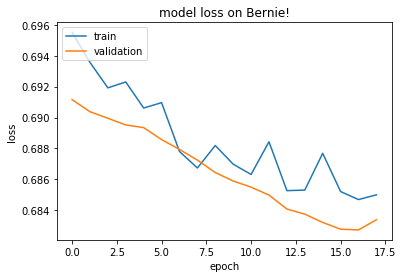

In [21]:
plot(era_models[100][1])

In [22]:
%%time
#era_models[119]
# now do a bunch of predictions

XV = data.x[ data.region=='validation' ]
YV = data.y[3][data.region=='validation']

# which era model to use per sample
M = np.argmax( model_dense.predict( data.x[ data.region=='validation' ] ), axis=1 )


In [149]:
from sklearn.metrics import log_loss


In [ ]:
%%time

# precompute predictions + losses for every example in the validation set for all eras
# seems inefficient but due to vectorization of prediction this is likely much faster
# seems to take about 6 seconds per era for 56084 signals in validation

num_val = XV.shape[0]
num_eras = len(era_models)
era_preds = np.zeros( (num_val, num_eras ) )

for era in range(num_eras):
    
    preds = era_models[era][0].predict( XV ).reshape(-1)
    
    era_preds[:, era] = preds
    
    print('computed era: %d' % era )
    

computed era: 0
computed era: 1
computed era: 2
computed era: 3
computed era: 4
computed era: 5
computed era: 6
computed era: 7
computed era: 8
computed era: 9
computed era: 10
computed era: 11
computed era: 12
computed era: 13
computed era: 14
computed era: 15
computed era: 16
computed era: 17
computed era: 18
computed era: 19
computed era: 20
computed era: 21
computed era: 22
computed era: 23
computed era: 24
computed era: 25
computed era: 26
computed era: 27
computed era: 28
computed era: 29
computed era: 30
computed era: 31
computed era: 32
computed era: 33
computed era: 34
computed era: 35
computed era: 36
computed era: 37
computed era: 38
computed era: 39
computed era: 40
computed era: 41
computed era: 42
computed era: 43
computed era: 44
computed era: 45
computed era: 46
computed era: 47
computed era: 48
computed era: 49
computed era: 50
computed era: 51
computed era: 52
computed era: 53
computed era: 54
computed era: 55
computed era: 56
computed era: 57
computed era: 58
compute

In [148]:
logloss(YV, era_preds[:,0], eps=1e-15)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [140]:
logloss(YV, era_preds[:,0] )

0.6931015361747412

In [129]:
%%time

best_preds = era_preds[ list(range(era_preds.shape[0])), list(M-1)]

Wall time: 13 ms


In [130]:
losses = log_loss( YV, best_preds )

np.mean(best_preds)

17.270099238457277

(array([1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8600e+02, 0.0000e+00,
        2.6600e+02, 1.4000e+01, 7.0000e+01, 2.0000e+00, 3.7000e+01,
        1.6320e+03, 2.9500e+02, 8.4400e+02, 1.4280e+03, 4.8030e+03,
        1.7291e+04, 1.4670e+03, 3.5030e+03, 1.1330e+03, 2.5910e+03,
        1.2170e+03, 1.7000e+02, 3.0100e+03, 8.7400e+02, 1.9700e+02,
        3.1900e+02, 0.0000e+00, 1.2923e+04, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9500e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0500e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+02]),
 array([17.16850785, 17.17264596, 17.17678406, 17.18092216, 17.18506026,
        17.18919837, 17.19333647, 17.19747457, 17.20161268, 17.20575078,
        17.20988888, 17.21402699, 17.21816509, 17.22230319, 17.2264413 ,
        17.2305794 , 17.2347175 , 17.2388556 , 17.24299371, 17.24713181,
        17.25126991, 17.25

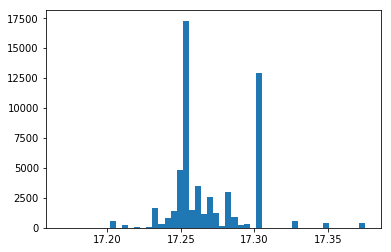

In [131]:
pyplot.hist(best_preds, bins=50)